# Variables With Prediction Modelling

Variables with future predictions are used to predict the Absorbance.

The variables are:
* Air temperature
* Daily Cumulated Rainfall
* Water Temperature
* Flow River (River Discharge in the Projections folder)


3 different models are used:
* linear regression
* random forest
* neural network

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Models
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

# Utils
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# Hyperparameter Optimization
import optuna

# MAPiE
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.metrics import regression_coverage_score

# Define paths

In [2]:
data_folder = os.path.join("..", "data")

projection_folder = os.path.join(data_folder, "future_projections")
processed_projections_folder = os.path.join(
    projection_folder, "processed"
)

interpolated_projections_folder = os.path.join(
    projection_folder, "interpolated"
)

raw_data_folder = os.path.join(data_folder, "raw_data")

# Load dataset

In [3]:
full_df = pd.read_excel(
    os.path.join(raw_data_folder, "raw_full_dataset.xlsx")
)

In [4]:
full_df

DateTime  nitrate    pH  turbidity  Ammonium  dissolvedoxygen  \
0    2012-08-29     5.54  8.31       3.42      0.01             4.71   
1    2012-08-30     5.56  8.29       3.10      0.02             4.75   
2    2012-08-31     5.51  8.31       3.60      0.04             5.08   
3    2012-09-01     5.49  8.40       4.00      0.06             5.68   
4    2012-09-02     5.39  8.43       3.97      0.15             5.98   
...         ...      ...   ...        ...       ...              ...   
4045 2023-09-26     7.56  8.30       3.96      0.03             5.46   
4046 2023-09-27     7.28  8.29       4.16      0.02             5.33   
4047 2023-09-28     7.34  8.27       3.80      0.02             5.23   
4048 2023-09-29     7.64  8.25       3.89      0.03             5.17   
4049 2023-09-30     8.14  8.23       3.93      0.02             5.12   

      watertemperature  Conductivity  redoxpotential  ABS254  \
0                28.10       1144.98          220.47    9.07   
1                27.57       1205.67          225.81   15.13   
2                26.37       1237.20          229.83   15.95   
3                25.04       1254.15          231.82     NaN   
4                24.75       1244.10          234.80   15.10   
...                ...           ...             ...     ...   
4045             25.95       1628.49          227.69    3.97   
4046             26.37       1610.67          227.02    3.81   
4047             26.60       1602.33          228.25    3.76   
4048             26.73       1613.81          230.54    4.18   
4049             26.74       1623.03          232.39    4.11   

      cumulated_rainfall_24h  flowriver  environmental_temperature  
0                        0.0     100.82                      27.02  
1                        0.4      97.40                      22.49  
2                        0.0      95.59                      21.03  
3                        0.0      94.97                      17.81  
4                        0.0      95.48                      19.43  
...                      ...        ...                        ...  
4045                     0.0      83.50                      20.50  
4046                     0.0      81.17                      21.76  
4047                     0.0      81.42                      22.17  
4048                     0.0      80.71                      22.03  
4049                     0.0      81.00                      22.28  

[4050 rows x 13 columns]

In [5]:
full_df.rename(
    columns={
        "flowriver": "Flow River",
        "cumulated_rainfall_24h": "Daily Cumulated Rainfall",
        "environmental_temperature": "Air Temperature",
        "nitrate": "Nitrate",
        "dissolvedoxygen": "Dissolved Oxygen",
        "turbidity": "Turbidity",
        "watertemperature": "Water Temperature",
        "redoxpotential": "Redox Potential",
        "ABS254": "Absorbance 254nm",
    },
    inplace=True,
)

In [6]:
full_df.isna().sum()

DateTime                      0
Nitrate                     176
pH                           99
Turbidity                   218
Ammonium                    413
Dissolved Oxygen            325
Water Temperature            86
Conductivity                141
Redox Potential             273
Absorbance 254nm            551
Daily Cumulated Rainfall     10
Flow River                   46
Air Temperature               1
dtype: int64

In [7]:
full_df = full_df.dropna()

# Remove Variables with no future projections

They are:
- Nitrate
- pH
- Ammonium
- Dissolved Oxygen
- Conductivity
- Redox Potential

In [8]:
full_df.drop(
    columns=[
        "Nitrate",
        "pH",
        "Ammonium",
        "Dissolved Oxygen",
        "Conductivity",
        "Redox Potential",
        "Turbidity",
    ],
    inplace=True,
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_46253/670764935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df.drop(


## Take the Monthly Average

In [9]:
full_df["Year"] = full_df["DateTime"].dt.year
full_df["Month"] = full_df["DateTime"].dt.month

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_46253/1583524510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df["Year"] = full_df["DateTime"].dt.year
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_46253/1583524510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df["Month"] = full_df["DateTime"].dt.month


In [10]:
# take the monthly average
monthly_avg_df = full_df.groupby(["Year", "Month"]).mean().reset_index()

In [11]:
full_df = monthly_avg_df

In [12]:
full_df["Season"] = full_df["Month"].apply(
    lambda x: "Winter"
    if x in [12, 1, 2]
    else "Spring"
    if x in [3, 4, 5]
    else "Summer"
    if x in [6, 7, 8]
    else "Autumn"
)

# convert Season to integer
full_df["Season"] = full_df["Season"].apply(
    lambda x: 1
    if x == "Winter"
    else 2
    if x == "Spring"
    else 3
    if x == "Summer"
    else 4
)

full_df["Timestamp"] = full_df["DateTime"].apply(
    lambda x: x.timestamp()
)

### Split Data

In [13]:
further_features = ["Year", "Season", "Month", "Timestamp"]

to_drop = ["Timestamp", "Season", "Month"]

further_features = [
    feature for feature in further_features if feature not in to_drop
]

X_columns_to_drop = to_drop + ["Absorbance 254nm"]

X = full_df[full_df.columns.difference(X_columns_to_drop)]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [14]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    X[X.columns.difference(["DateTime"])]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        X.columns.difference(["DateTime"])
    ),
)

X_poly["DateTime"] = X["DateTime"].values

In [15]:
X_train_fit = X_poly[X_poly.columns.difference(["DateTime"])]
y_train_fit = y[y.columns.difference(["DateTime"])]

In [16]:
scaler = StandardScaler()
# scale the data and keep the column names
X_train_fit = scaler.fit_transform(X_train_fit)

X_train_fit = pd.DataFrame(
    X_train_fit, columns=X_poly.columns.difference(["DateTime"])
)

In [17]:
X_train_fit = X[X.columns.difference(["DateTime"])]
y_train_fit = y.copy()

In [18]:
scaler = StandardScaler()
# scale the data and keep the column names
X_train_fit = scaler.fit_transform(X_train_fit)

X_train_fit = pd.DataFrame(
    X_train_fit, columns=X.columns.difference(["DateTime"])
)

# Projections

## Load Input Projections

In [19]:
air_temp_rcp45_df = pd.read_excel(os.path.join(interpolated_projections_folder, 'air_temp_rcp45.xlsx'))
air_temp_rcp85_df = pd.read_excel(os.path.join(interpolated_projections_folder, 'air_temp_rcp85.xlsx'))

rain_rcp45_df = pd.read_excel(os.path.join(interpolated_projections_folder, 'precipitation_rcp45.xlsx'))
rain_rcp85_df = pd.read_excel(os.path.join(interpolated_projections_folder, 'precipitation_rcp85.xlsx'))

flow_rcp45_df = pd.read_excel(os.path.join(interpolated_projections_folder, 'flow_rcp45.xlsx'))
flow_rcp85_df = pd.read_excel(os.path.join(interpolated_projections_folder, 'flow_rcp85.xlsx'))

water_temp_rcp45_df = pd.read_excel(os.path.join(interpolated_projections_folder, 'water_temp_rcp45.xlsx'))
water_temp_rcp85_df = pd.read_excel(os.path.join(interpolated_projections_folder, 'water_temp_rcp85.xlsx'))

## Create Datasets

### RCP 4.5

In [20]:
rcp45_df = air_temp_rcp45_df.copy()
rcp45_df.rename(columns={'Value': 'Air Temperature'}, inplace=True)

rcp45_df['Daily Cumulated Rainfall'] = rain_rcp45_df['Value'].values
rcp45_df['Flow River'] = flow_rcp45_df['Value'].values
rcp45_df['Water Temperature'] = water_temp_rcp45_df['Value'].values

rcp45_df.drop(columns=['Unnamed: 0'], inplace=True)
rcp45_df.drop(columns=['Month'], inplace=True)
rcp45_df['Year'] = rcp45_df['DateTime'].dt.year

In [21]:
rcp45_df

Air Temperature   DateTime  Daily Cumulated Rainfall  Flow River  \
0            5.994035 2000-01-15                  1.076563  501.738647   
1            6.923290 2000-02-15                  2.324204  547.229370   
2            8.482099 2000-03-15                  1.900532  557.117981   
3           11.252884 2000-04-15                  2.015732  577.365356   
4           14.468916 2000-05-15                  1.397484  619.149353   
...               ...        ...                       ...         ...   
1207        24.687569 2100-08-15                  0.370926  219.216675   
1208        21.011845 2100-09-15                  1.206676  176.480667   
1209        16.178974 2100-10-15                  1.040267  263.684326   
1210        11.193771 2100-11-15                  1.882367  392.330994   
1211         8.155241 2100-12-15                  1.249669  495.868988   

      Water Temperature  Year  
0             10.401983  2000  
1              9.977690  2000  
2             10.518540  2000  
3             11.898833  2000  
4             13.649767  2000  
...                 ...   ...  
1207          21.289766  2100  
1208          22.000534  2100  
1209          20.951900  2100  
1210          18.140700  2100  
1211          14.558333  2100  

[1212 rows x 6 columns]

### RCP 8.5

In [22]:
rcp85_df = air_temp_rcp85_df.copy()
rcp85_df.rename(columns={'Value': 'Air Temperature'}, inplace=True)

rcp85_df['Daily Cumulated Rainfall'] = rain_rcp85_df['Value'].values
rcp85_df['Flow River'] = flow_rcp85_df['Value'].values
rcp85_df['Water Temperature'] = water_temp_rcp85_df['Value'].values

rcp85_df.drop(columns=['Unnamed: 0'], inplace=True)
rcp85_df.drop(columns=['Month'], inplace=True)
rcp85_df['Year'] = rcp85_df['DateTime'].dt.year

In [23]:
rcp85_df

Air Temperature   DateTime  Daily Cumulated Rainfall  Flow River  \
0            5.994035 2000-01-15                  1.076563  501.738647   
1            6.923290 2000-02-15                  2.324204  547.229370   
2            8.482099 2000-03-15                  1.900532  557.117981   
3           11.252884 2000-04-15                  2.015732  577.365356   
4           14.468916 2000-05-15                  1.397484  619.149353   
...               ...        ...                       ...         ...   
1207        26.614027 2100-08-15                  0.264394  160.920334   
1208        22.744684 2100-09-15                  1.865488  174.756668   
1209        17.613710 2100-10-15                  0.959106  222.492004   
1210        13.031203 2100-11-15                  1.947672  307.565338   
1211        10.241478 2100-12-15                  1.126644  350.726990   

      Water Temperature  Year  
0             10.401983  2000  
1              9.977690  2000  
2             10.518540  2000  
3             11.898833  2000  
4             13.649767  2000  
...                 ...   ...  
1207          22.229467  2100  
1208          23.110233  2100  
1209          22.183233  2100  
1210          19.502333  2100  
1211          16.179768  2100  

[1212 rows x 6 columns]

## Predictions

### XGBoost

#### RCP 4.5

##### Prepare Data

In [24]:
further_features = ['Year']

last_train_date = full_df['DateTime'].max()

rcp45_test_df = rcp45_df[rcp45_df['DateTime'] > last_train_date]

In [25]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    rcp45_test_df[rcp45_test_df.columns.difference(["DateTime"])]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        rcp45_test_df.columns.difference(["DateTime"])
    ),
)

X_poly["DateTime"] = rcp45_test_df["DateTime"].values

In [26]:
X_test_fit = X_poly[X_poly.columns.difference(["DateTime"])]

In [27]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_poly.columns.difference(["DateTime"])
)

In [28]:
X_test_fit = rcp45_test_df[rcp45_test_df.columns.difference(["DateTime"])]

In [29]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=rcp45_test_df.columns.difference(["DateTime"])
)

##### Train Model

In [30]:
# sort the columns
X_train_fit = X_train_fit.reindex(sorted(X_train_fit.columns), axis=1)
X_test_fit = X_test_fit.reindex(sorted(X_test_fit.columns), axis=1)

In [31]:
best_params = {
    'objective': 'reg:squarederror',
    'booster': 'gblinear',
    'eta': 0.021222820197838683,
    'reg_lambda': 1.2716135487076726e-07,
    'reg_alpha': 0.25584966658518155,
    'learning_rate': 0.6602531811820622,
    'n_estimators': 369,
    'updater': 'shotgun'
}

In [32]:
booster = xgb.XGBRegressor(
    random_state=42,
    **best_params,
)

booster.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.021222820197838683,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.6602531811820622, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=369, n_jobs=None,
             num_parallel_tree=None, ...)

##### Feature Importance

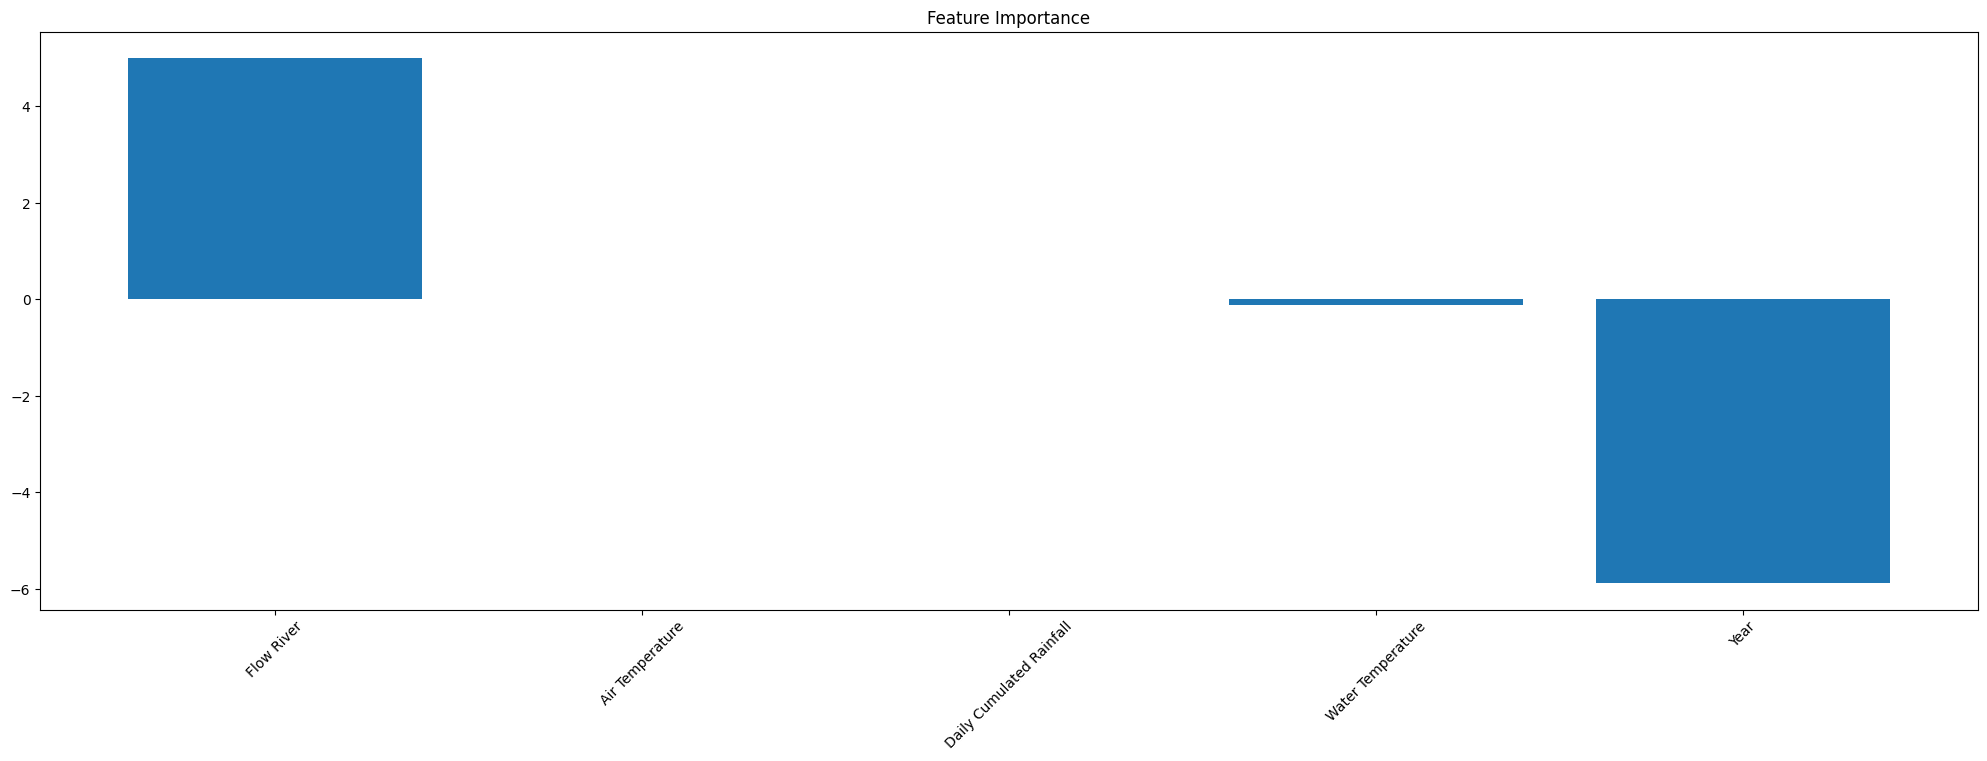

In [33]:
# show the importance of each feature in the model
feature_importance = pd.DataFrame()
feature_importance["feature"] = booster.feature_names_in_
feature_importance["importance"] = -booster.feature_importances_

feature_importance = feature_importance.sort_values(
    by="importance", ascending=False
)

# plot the importance of each feature
plt.figure(figsize=(25, 7.5))
plt.bar(
    x=feature_importance["feature"],
    height=feature_importance["importance"],
)

# rotate the x axis words by 45°
plt.xticks(rotation=45)

plt.title("Feature Importance")
plt.show()

##### Predictions

In [34]:
mapie_cqr = MapieRegressor(booster, method='naive', random_state=42)
mapie_cqr.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

MapieRegressor(estimator=XGBRegressor(base_score=None, booster='gblinear',
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eta=0.021222820197838683,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=0.6602531811820622,
                                      max_bin=None, max_cat_threshold=None,
                                      max_cat_to_onehot=None,
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=369,
                                      n_jobs=None, num_parallel_tree=None, ...),
               method='naive', random_state=42)

In [35]:
# add month to the test data to get the predictions
X_test_fit['Month'] = rcp45_test_df['DateTime'].dt.month.values

In [36]:
alpha = 0.05

predictions_per_month = {}

# Evaluate prediction and coverage level on testing set for each month
for month in range(1, 13):
    test_fit = X_test_fit[X_test_fit["Month"] == month]
    rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]
    
    # drop the month column
    test_fit = test_fit[test_fit.columns.difference(["Month"])]
    
    y_med, y_pis_cqr = mapie_cqr.predict(test_fit, alpha=alpha)
    y_lower = y_pis_cqr[:, 0, 0]
    y_upper = y_pis_cqr[:, 1, 0]
    
    predictions_per_month[month] = {
        "y_med": y_med,
        "y_lower": y_lower,
        "y_upper": y_upper,
    }

In [37]:
X_test_fit.drop(columns=['Month'], inplace=True)

In [38]:
# evaluate on all the months
y_med, y_pis_cqr = mapie_cqr.predict(X_test_fit, alpha=alpha)
y_lower = y_pis_cqr[:, 0, 0]
y_upper = y_pis_cqr[:, 1, 0]

##### Plots

In [39]:
# get training residuals
train_predictions = booster.predict(X_train_fit)
train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

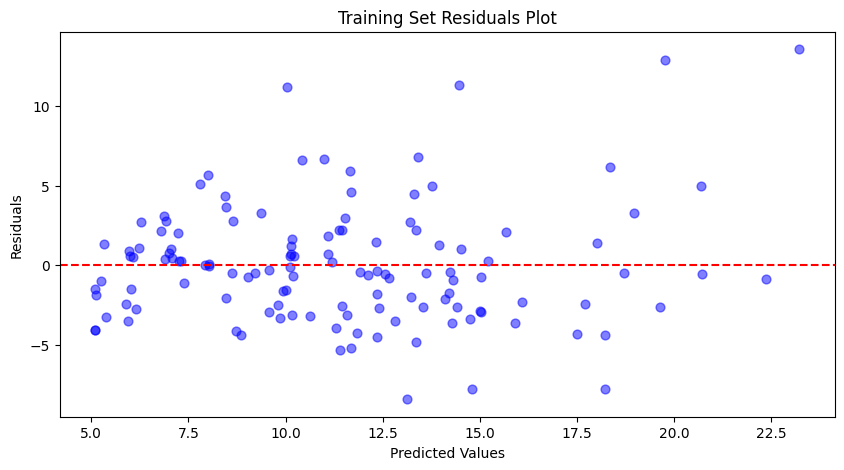

In [40]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

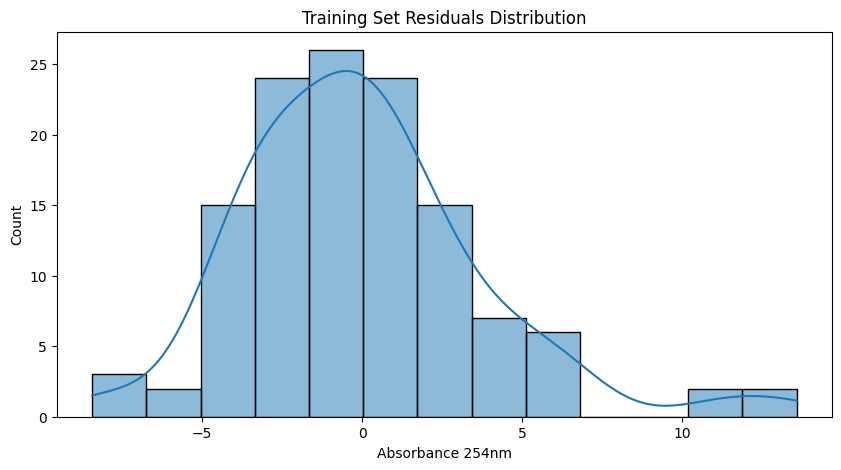

In [41]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

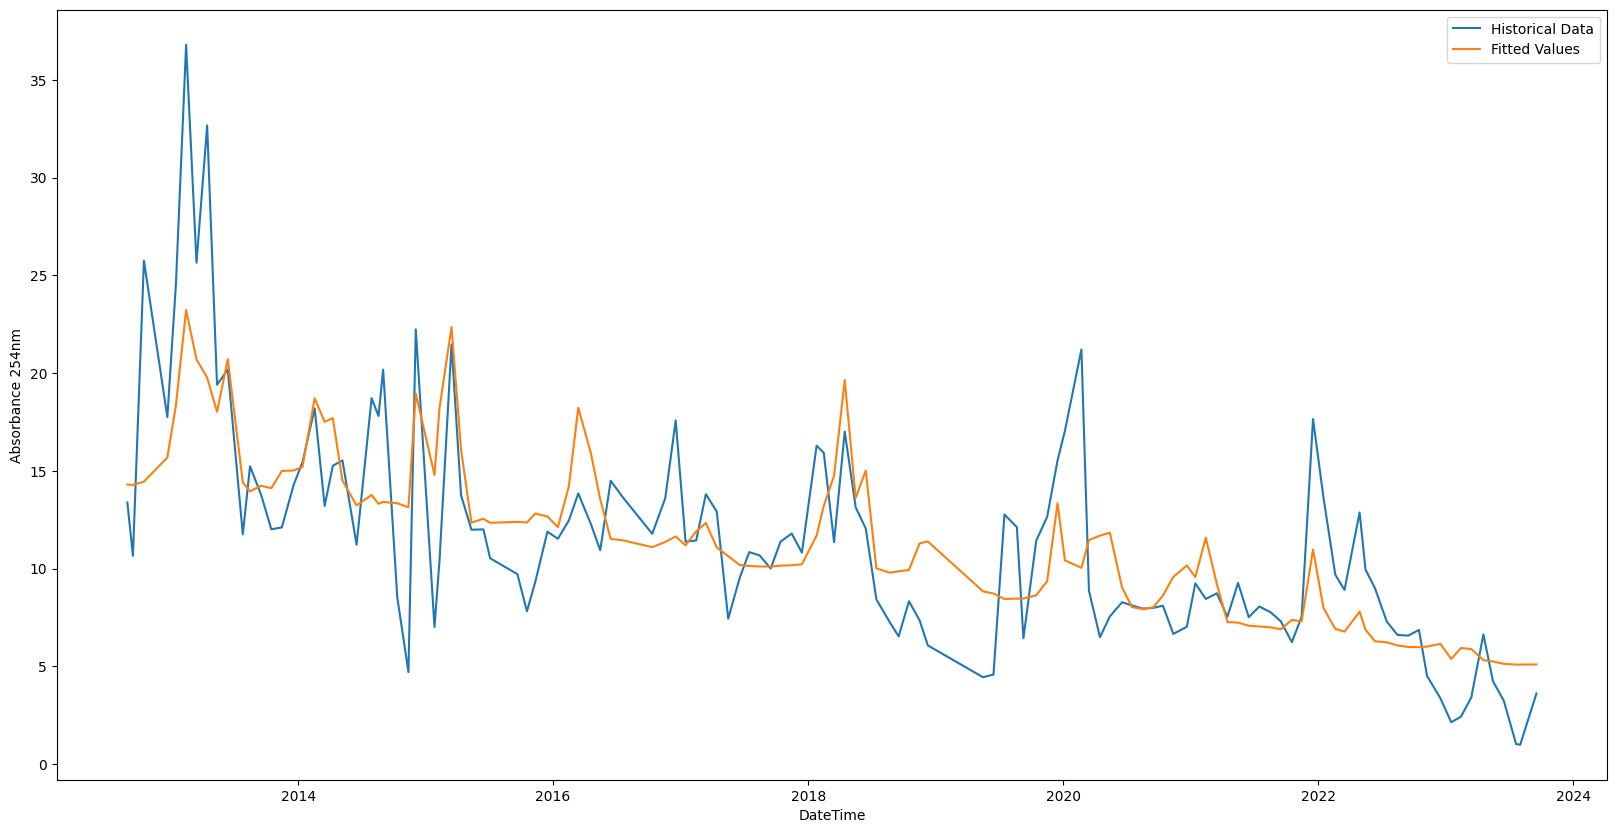

In [42]:
# plot the time series fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y["DateTime"],
    y=y["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y["DateTime"], y=train_predictions, label="Fitted Values"
)

plt.show()

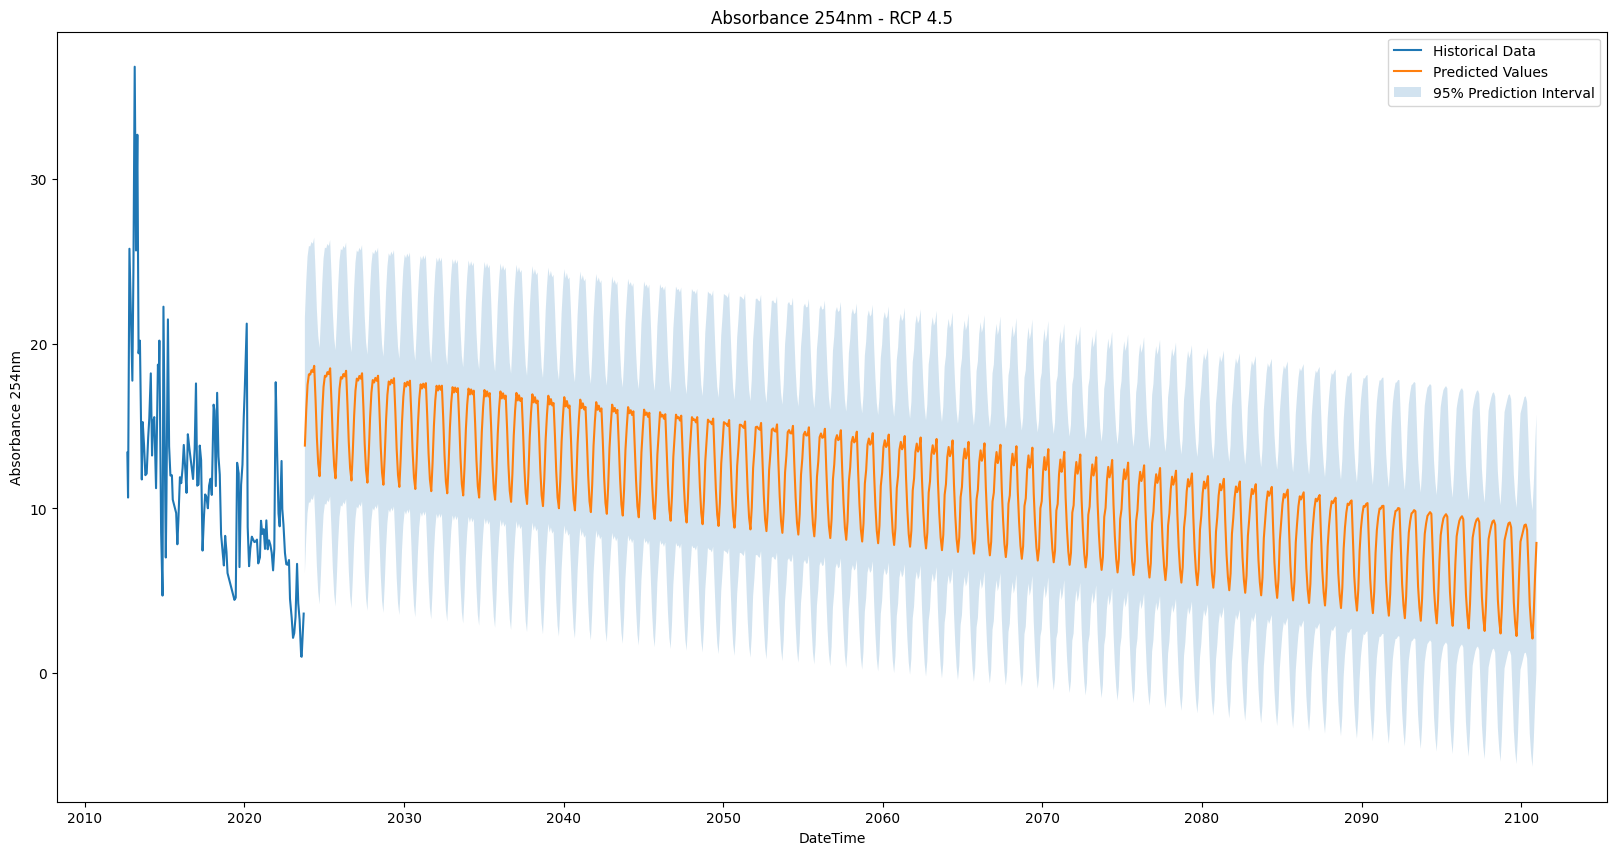

In [43]:
# all the predictions
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )


sns.lineplot(x=rcp45_test_df['DateTime'], y=y_med, label=f"Predicted Values")
# plot std of predictions
plt.fill_between(
    rcp45_test_df['DateTime'],
    y_lower,
    y2=y_upper,
    alpha=0.2,
    label="95% Prediction Interval",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box

plt.title(
    f"Absorbance 254nm - RCP 4.5"
)

plt.legend()
plt.show()

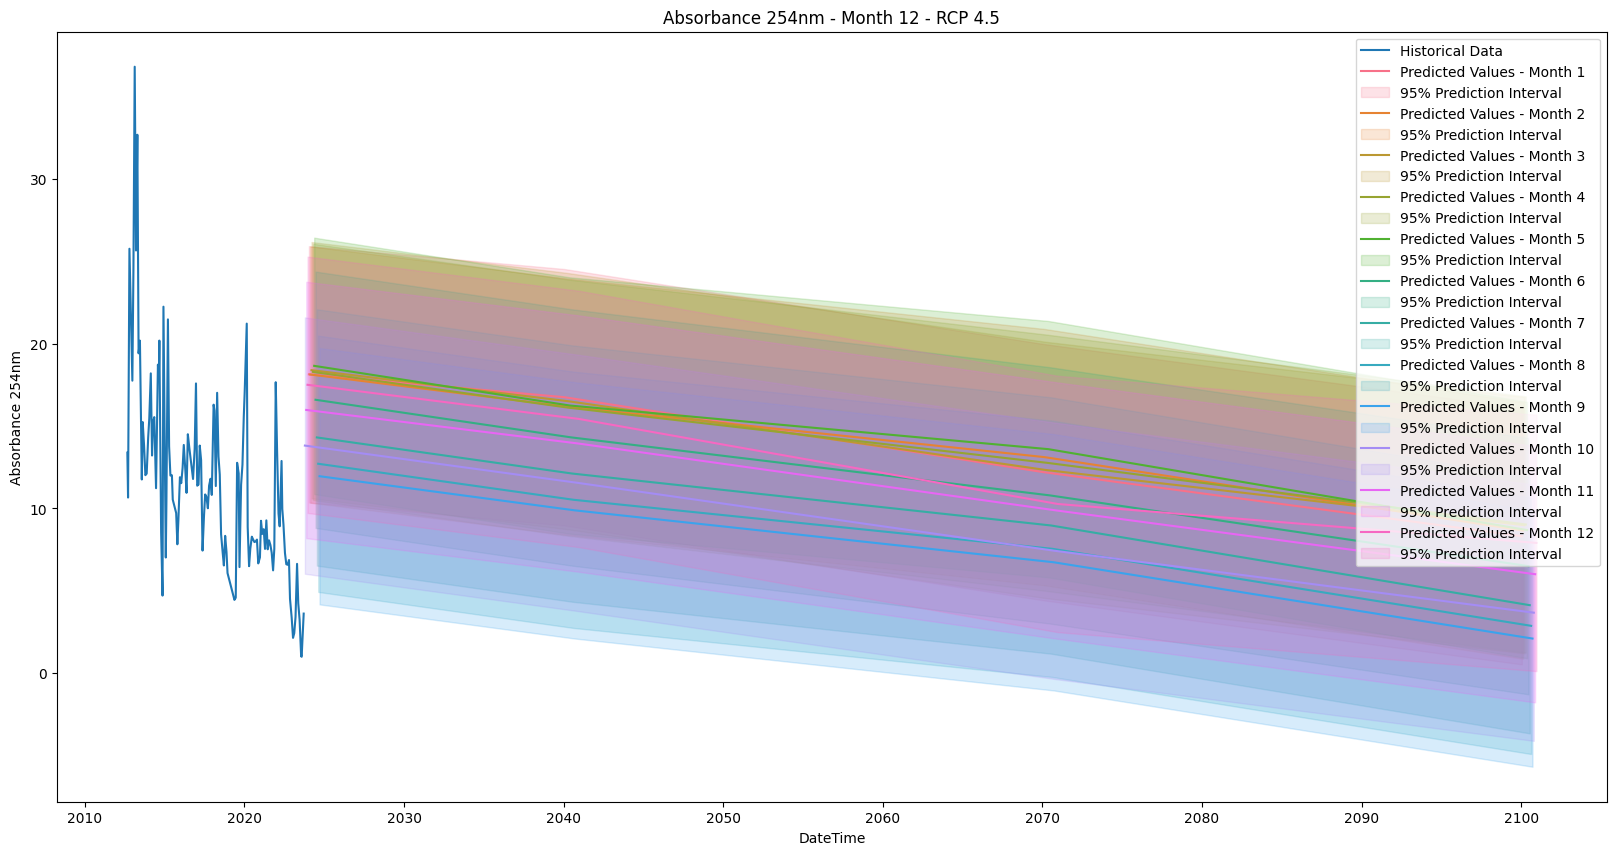

In [44]:
# predictions per month
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )

# give me a list of 12 colors
colors = sns.color_palette("husl", 12)

for month in range(1, 13):
    y_med = predictions_per_month[month]["y_med"]
    y_lower = predictions_per_month[month]["y_lower"]
    y_upper = predictions_per_month[month]["y_upper"]
    
    

    # plot the time series fitted values

    sns.lineplot(x=rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]['DateTime'], y=y_med, label=f"Predicted Values - Month {month}", color=colors[month-1])
    # plot std of predictions
    plt.fill_between(
        rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]['DateTime'],
        y_lower,
        y2=y_upper,
        alpha=0.2,
        label="95% Prediction Interval",
        color=colors[month-1],
    )
    plt.xlabel("DateTime")
    plt.ylabel("Absorbance 254nm")

    # add rmse and r2 to the plot in a box

    plt.title(
        f"Absorbance 254nm - Month {month} - RCP 4.5"
    )

    plt.legend()
plt.show()

##### Store Results

In [45]:
boost_pred = y_med
boost_lower_bound = y_lower
boost_upper_bound = y_upper

#### RCP 8.5

##### Prepare Data

In [46]:
further_features = ['Year']

last_train_date = full_df['DateTime'].max()

rcp85_test_df = rcp85_df[rcp85_df['DateTime'] > last_train_date]

In [47]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    rcp85_test_df[rcp85_test_df.columns.difference(["DateTime"])]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        rcp85_test_df.columns.difference(["DateTime"])
    ),
)

X_poly["DateTime"] = rcp85_test_df["DateTime"].values

In [48]:
X_test_fit = X_poly[X_poly.columns.difference(["DateTime"])]

In [49]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_poly.columns.difference(["DateTime"])
)

In [50]:
X_test_fit = rcp85_test_df[rcp85_test_df.columns.difference(["DateTime"])]

In [51]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=rcp85_test_df.columns.difference(["DateTime"])
)

##### Train Model

In [52]:
# sort the columns
X_train_fit = X_train_fit.reindex(sorted(X_train_fit.columns), axis=1)
X_test_fit = X_test_fit.reindex(sorted(X_test_fit.columns), axis=1)

In [53]:
best_params = {
    'objective': 'reg:squarederror',
    'booster': 'gblinear',
    'eta': 0.021222820197838683,
    'reg_lambda': 1.2716135487076726e-07,
    'reg_alpha': 0.25584966658518155,
    'learning_rate': 0.6602531811820622,
    'n_estimators': 369,
    'updater': 'shotgun'
}

In [54]:
booster = xgb.XGBRegressor(
    random_state=42,
    **best_params,
)

booster.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.021222820197838683,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.6602531811820622, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=369, n_jobs=None,
             num_parallel_tree=None, ...)

##### Feature Importance

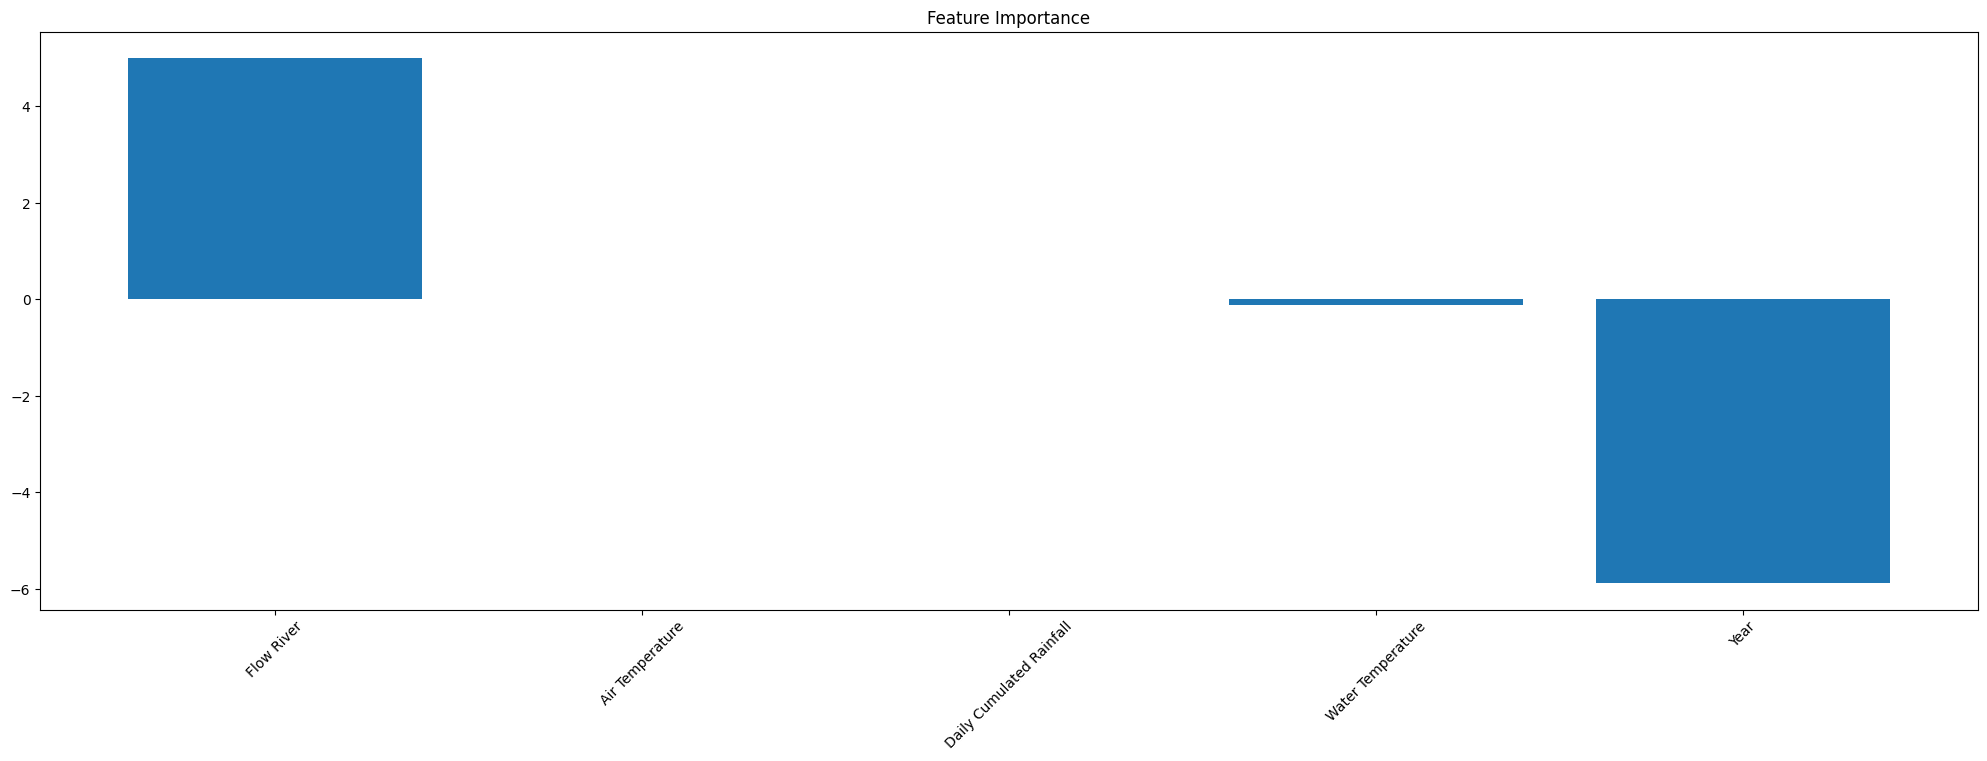

In [55]:
# show the importance of each feature in the model
feature_importance = pd.DataFrame()
feature_importance["feature"] = booster.feature_names_in_
feature_importance["importance"] = -booster.feature_importances_

feature_importance = feature_importance.sort_values(
    by="importance", ascending=False
)

# plot the importance of each feature
plt.figure(figsize=(25, 7.5))
plt.bar(
    x=feature_importance["feature"],
    height=feature_importance["importance"],
)

# rotate the x axis words by 45°
plt.xticks(rotation=45)

plt.title("Feature Importance")
plt.show()

##### Predictions

In [56]:
mapie_cqr = MapieRegressor(booster, method='naive', random_state=42)
mapie_cqr.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

MapieRegressor(estimator=XGBRegressor(base_score=None, booster='gblinear',
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eta=0.021222820197838683,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=0.6602531811820622,
                                      max_bin=None, max_cat_threshold=None,
                                      max_cat_to_onehot=None,
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=369,
                                      n_jobs=None, num_parallel_tree=None, ...),
               method='naive', random_state=42)

In [57]:
# add month to the test data to get the predictions
X_test_fit['Month'] = rcp85_test_df['DateTime'].dt.month.values

In [58]:
alpha = 0.05

predictions_per_month = {}

# Evaluate prediction and coverage level on testing set for each month
for month in range(1, 13):
    test_fit = X_test_fit[X_test_fit["Month"] == month]
    rcp85_test_df[rcp85_test_df['DateTime'].dt.month == month]
    
    # drop the month column
    test_fit = test_fit[test_fit.columns.difference(["Month"])]
    
    y_med, y_pis_cqr = mapie_cqr.predict(test_fit, alpha=alpha)
    y_lower = y_pis_cqr[:, 0, 0]
    y_upper = y_pis_cqr[:, 1, 0]
    
    predictions_per_month[month] = {
        "y_med": y_med,
        "y_lower": y_lower,
        "y_upper": y_upper,
    }

In [59]:
X_test_fit.drop(columns=['Month'], inplace=True)

In [60]:
# evaluate on all the months
y_med, y_pis_cqr = mapie_cqr.predict(X_test_fit, alpha=alpha)
y_lower = y_pis_cqr[:, 0, 0]
y_upper = y_pis_cqr[:, 1, 0]

##### Plots

In [61]:
# get training residuals
train_predictions = booster.predict(X_train_fit)
train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

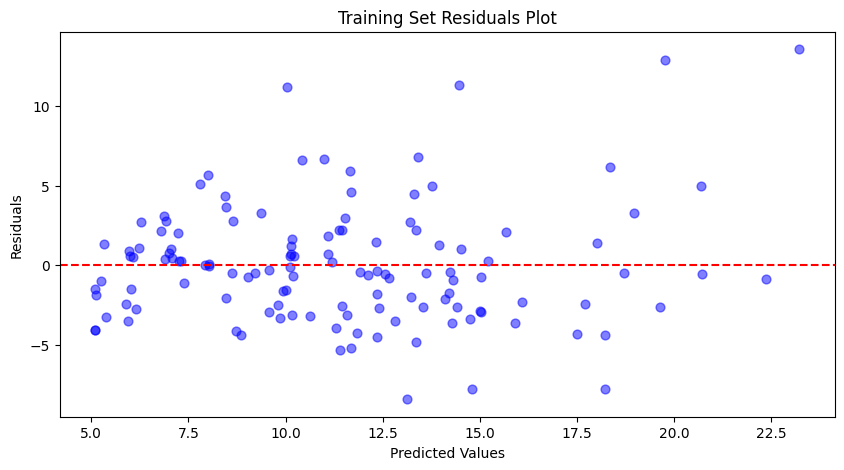

In [62]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

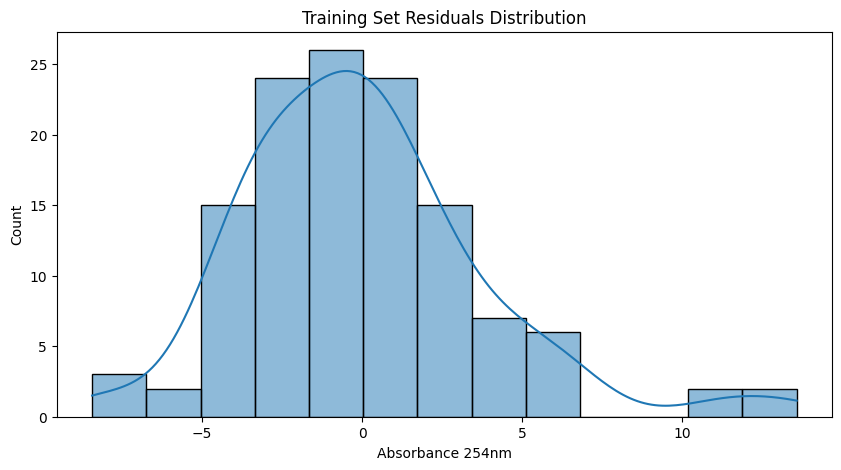

In [63]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

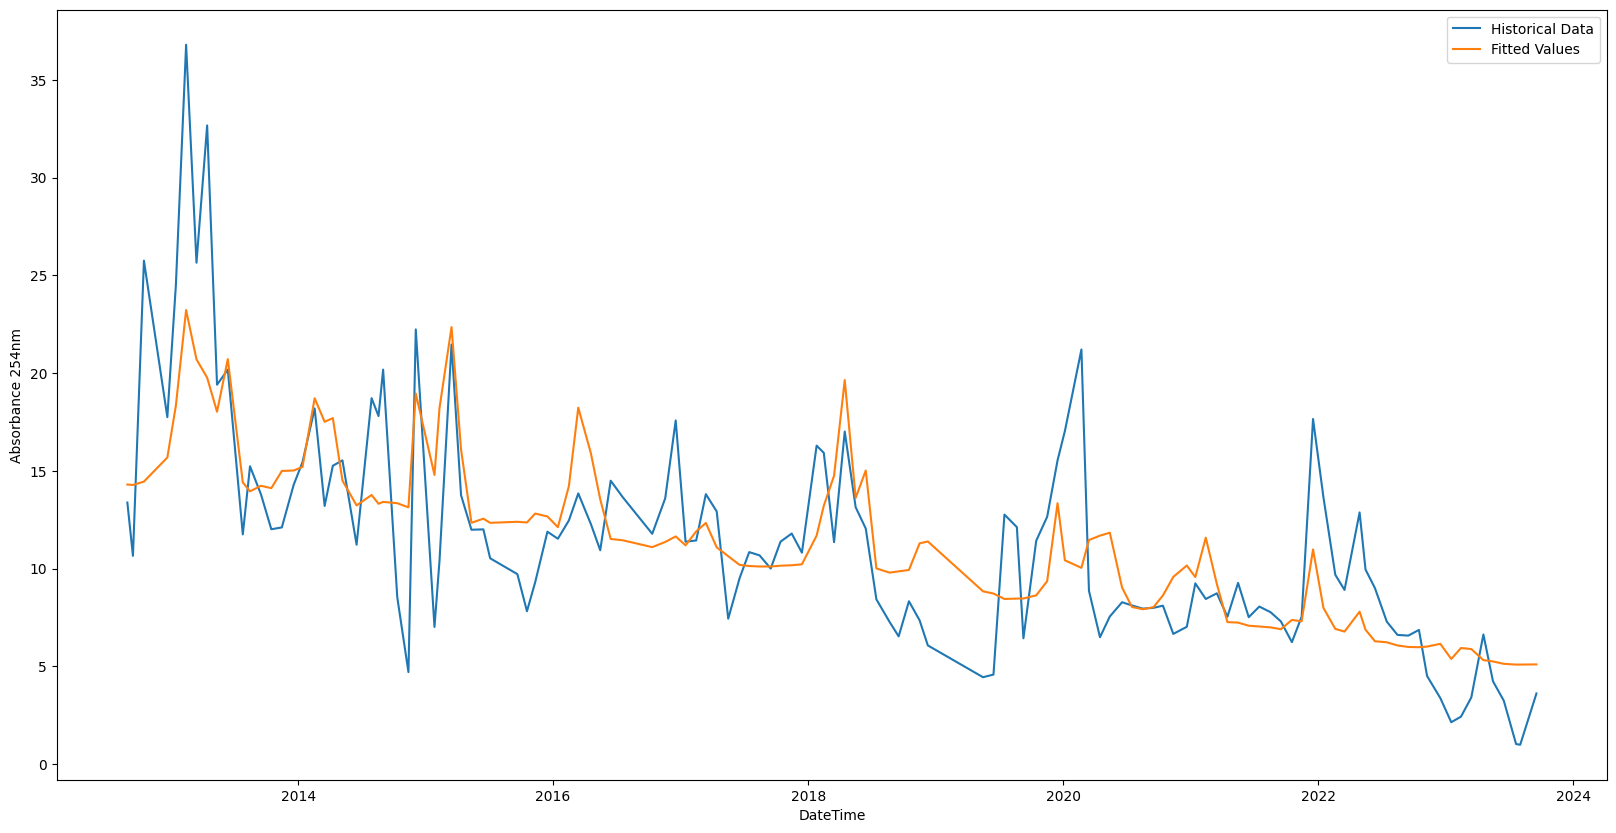

In [64]:
# plot the time series fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y["DateTime"],
    y=y["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y["DateTime"], y=train_predictions, label="Fitted Values"
)

plt.show()

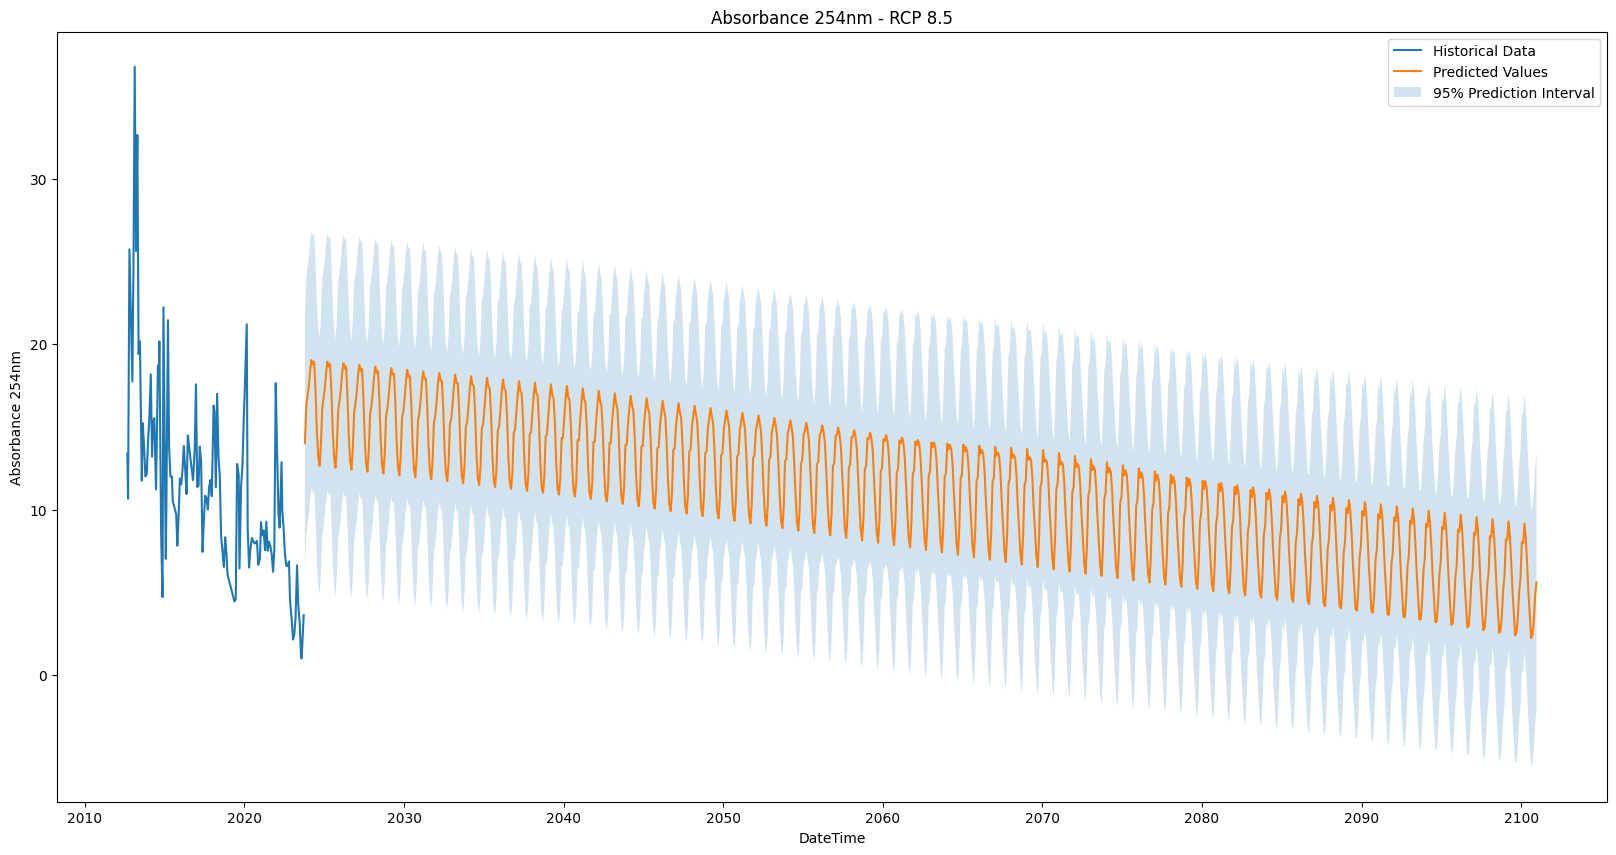

In [65]:
# all the predictions
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )


sns.lineplot(x=rcp45_test_df['DateTime'], y=y_med, label=f"Predicted Values")
# plot std of predictions
plt.fill_between(
    rcp45_test_df['DateTime'],
    y_lower,
    y2=y_upper,
    alpha=0.2,
    label="95% Prediction Interval",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box

plt.title(
    f"Absorbance 254nm - RCP 8.5"
)

plt.legend()
plt.show()

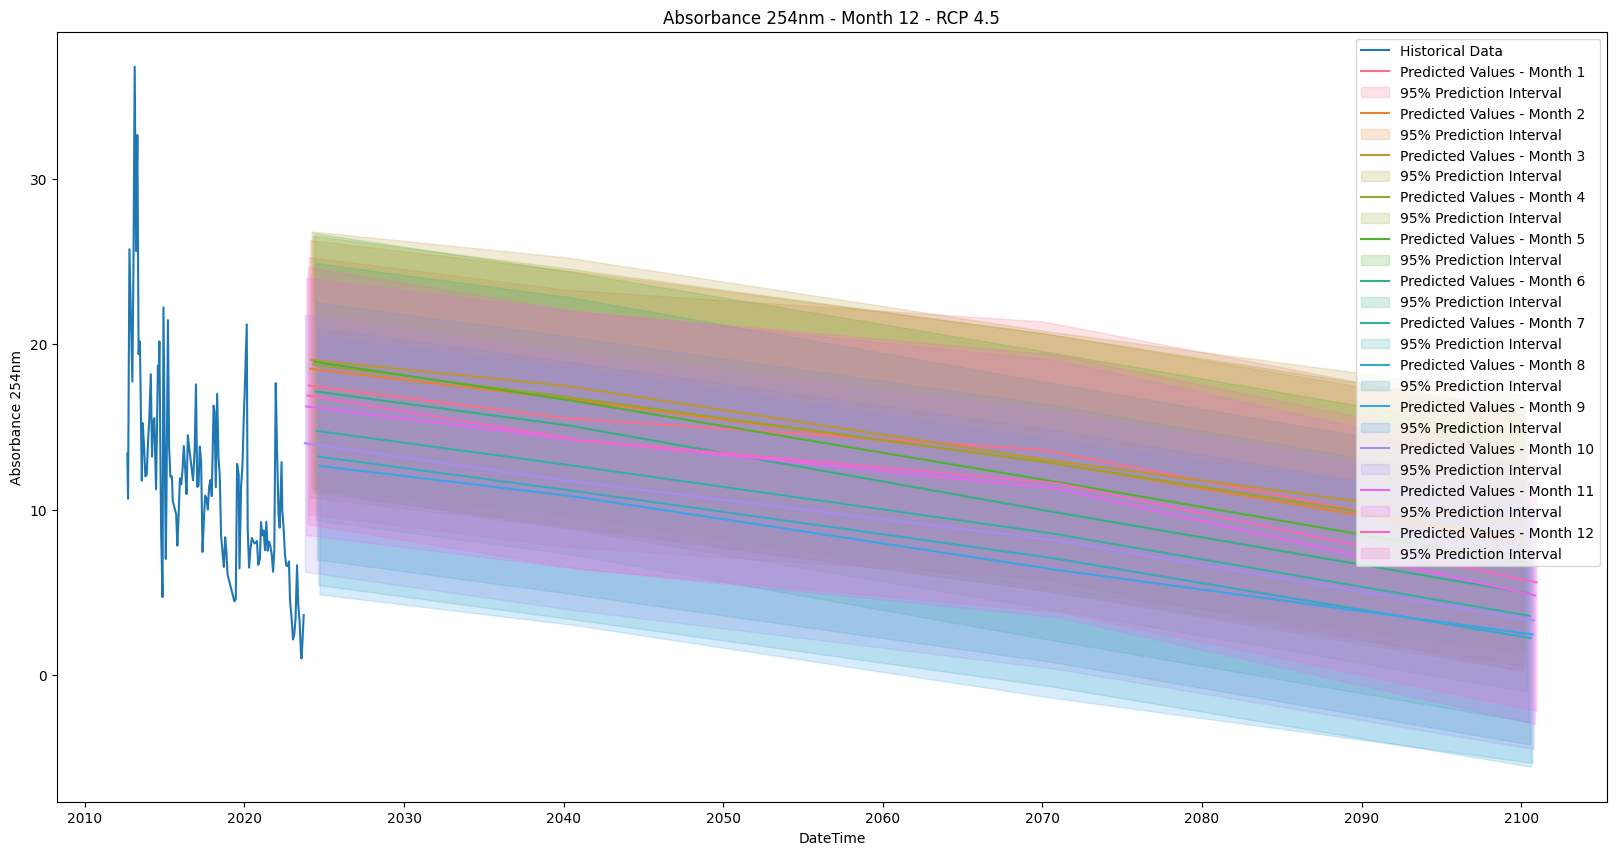

In [66]:
# predictions per month
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )

# give me a list of 12 colors
colors = sns.color_palette("husl", 12)

for month in range(1, 13):
    y_med = predictions_per_month[month]["y_med"]
    y_lower = predictions_per_month[month]["y_lower"]
    y_upper = predictions_per_month[month]["y_upper"]
    
    

    # plot the time series fitted values

    sns.lineplot(x=rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]['DateTime'], y=y_med, label=f"Predicted Values - Month {month}", color=colors[month-1])
    # plot std of predictions
    plt.fill_between(
        rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]['DateTime'],
        y_lower,
        y2=y_upper,
        alpha=0.2,
        label="95% Prediction Interval",
        color=colors[month-1]
    )
    plt.xlabel("DateTime")
    plt.ylabel("Absorbance 254nm")

    # add rmse and r2 to the plot in a box

    plt.title(
        f"Absorbance 254nm - Month {month} - RCP 4.5"
    )

    plt.legend()
plt.show()

##### Store Results

In [67]:
boost_pred = y_med
boost_lower_bound = y_lower
boost_upper_bound = y_upper

### LightGBM (Random Forest with Linear Regressors on leaves)

#### RCP 4.5

##### Prepare Data

In [68]:
further_features = ['Year']

last_train_date = full_df['DateTime'].max()

rcp45_test_df = rcp45_df[rcp45_df['DateTime'] > last_train_date]

In [69]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    rcp45_test_df[rcp45_test_df.columns.difference(["DateTime"])]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        rcp45_test_df.columns.difference(["DateTime"])
    ),
)

X_poly["DateTime"] = rcp45_test_df["DateTime"].values

In [70]:
X_test_fit = X_poly[X_poly.columns.difference(["DateTime"])]

In [71]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_poly.columns.difference(["DateTime"])
)

In [72]:
X_test_fit = rcp45_test_df[rcp45_test_df.columns.difference(["DateTime"])]

In [73]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=rcp45_test_df.columns.difference(["DateTime"])
)

##### Train Model

In [74]:
# sort the columns
X_train_fit = X_train_fit.reindex(sorted(X_train_fit.columns), axis=1)
X_test_fit = X_test_fit.reindex(sorted(X_test_fit.columns), axis=1)

In [75]:
params = {
    'n_estimators': 16,
    'learning_rate': 0.6192800859019298,
    'max_depth': 16,
    'num_leaves': 20,
    'min_data_in_leaf': 34,
    'lambda_l1': 1.8585248563175933,
    'lambda_l2': 0.020368547806226774,
    'min_split_gain': 2.5,
    'subsample': 0.5639096844841955,
    'bagging_fraction': 0.026474369917739878,
    'feature_fraction': 0.0012608584366219668,
    'min_child_samples': 33,
    'max_bin': 20
}

###### Train model with mapie

In [76]:
alpha = 0.1
estimator = LGBMRegressor(
    objective="regression", random_state=42, linear_tree=True, **params
)

estimator.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

[LightGBM] [Warning] lambda_l1 is set=1.8585248563175933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8585248563175933
[LightGBM] [Warning] lambda_l2 is set=0.020368547806226774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020368547806226774
[LightGBM] [Warning] bagging_fraction is set=0.026474369917739878, subsample=0.5639096844841955 will be ignored. Current value: bagging_fraction=0.026474369917739878
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.0012608584366219668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0012608584366219668
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1.8585248563175933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8585248563175933
[LightGBM] [Warning] lambda_l2 is set=0.020368547806226774, reg_lamb

LGBMRegressor(bagging_fraction=0.026474369917739878,
              feature_fraction=0.0012608584366219668,
              lambda_l1=1.8585248563175933, lambda_l2=0.020368547806226774,
              learning_rate=0.6192800859019298, linear_tree=True, max_bin=20,
              max_depth=16, min_child_samples=33, min_data_in_leaf=34,
              min_split_gain=2.5, n_estimators=16, num_leaves=20,
              objective='regression', random_state=42,
              subsample=0.5639096844841955)

##### Feature Importance

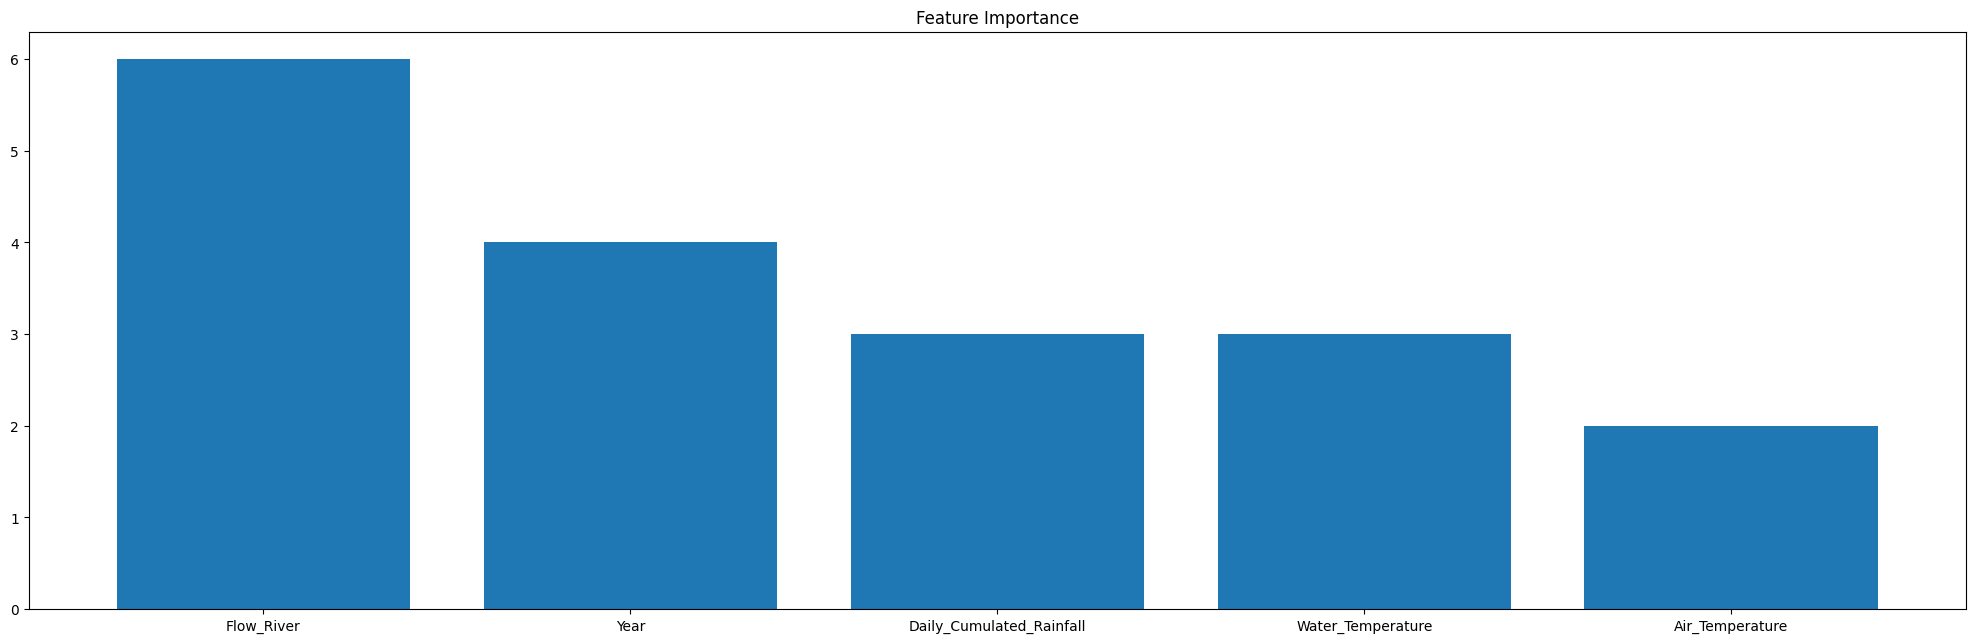

In [77]:
# show the importance of each feature in the model
feature_importance = pd.DataFrame()
feature_importance["feature"] = estimator.feature_name_
feature_importance["importance"] = estimator.feature_importances_

feature_importance = feature_importance.sort_values(
    by="importance", ascending=False
)

# plot the importance of each feature
plt.figure(figsize=(25, 7.5))
plt.bar(
    x=feature_importance["feature"],
    height=feature_importance["importance"],
)
plt.title("Feature Importance")
plt.show()

##### Predictions

In [78]:
# add month to the test data to get the predictions
X_test_fit['Month'] = rcp45_test_df['DateTime'].dt.month.values

In [79]:
alpha = 0.05

predictions_per_month = {}

# Evaluate prediction and coverage level on testing set for each month
for month in range(1, 13):
    test_fit = X_test_fit[X_test_fit["Month"] == month]
    rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]
    
    # drop the month column
    test_fit = test_fit[test_fit.columns.difference(["Month"])]
    
    y_med_month, y_pis_cqr = mapie_cqr.predict(test_fit, alpha=alpha)
    y_lower_month = y_pis_cqr[:, 0, 0]
    y_upper_month = y_pis_cqr[:, 1, 0]
    
    predictions_per_month[month] = {
        "y_med": y_med_month,
        "y_lower": y_lower_month,
        "y_upper": y_upper_month,
    }

In [80]:
X_test_fit.drop(columns=['Month'], inplace=True)

In [81]:
# evaluate on all the months
y_med, y_pis_cqr = mapie_cqr.predict(X_test_fit, alpha=alpha)
y_lower = y_pis_cqr[:, 0, 0]
y_upper = y_pis_cqr[:, 1, 0]

##### Plots

In [82]:
# get training residuals
train_predictions, _ = mapie_cqr.predict(X_train_fit, alpha=alpha)
train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

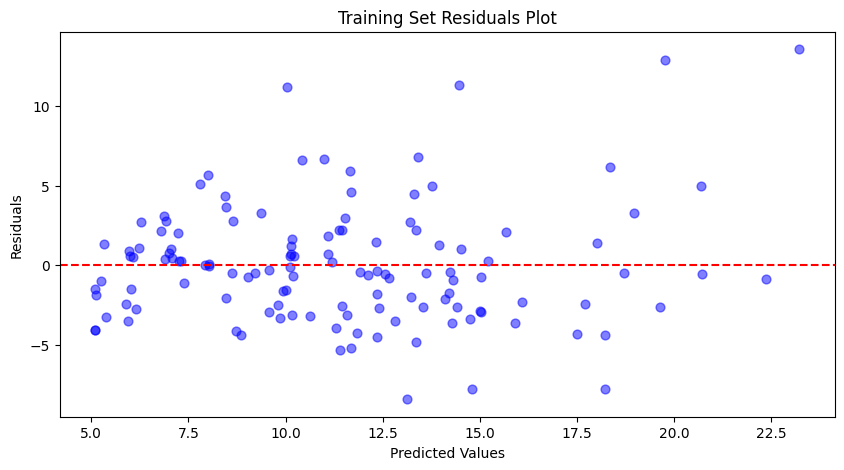

In [83]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

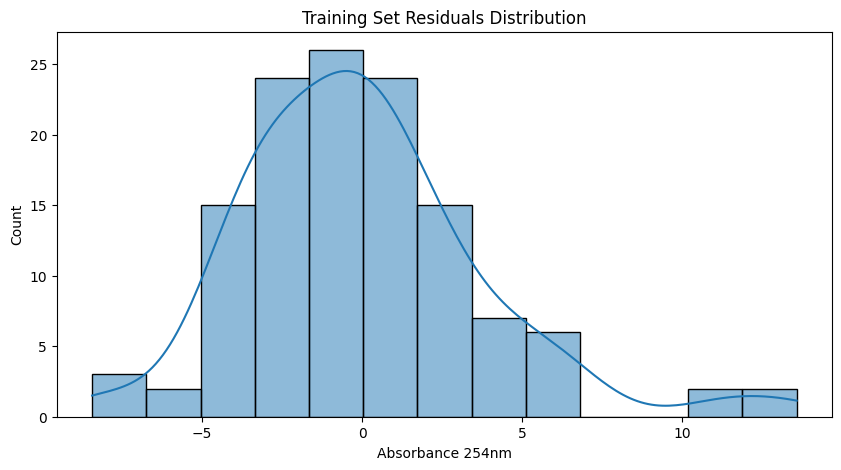

In [84]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

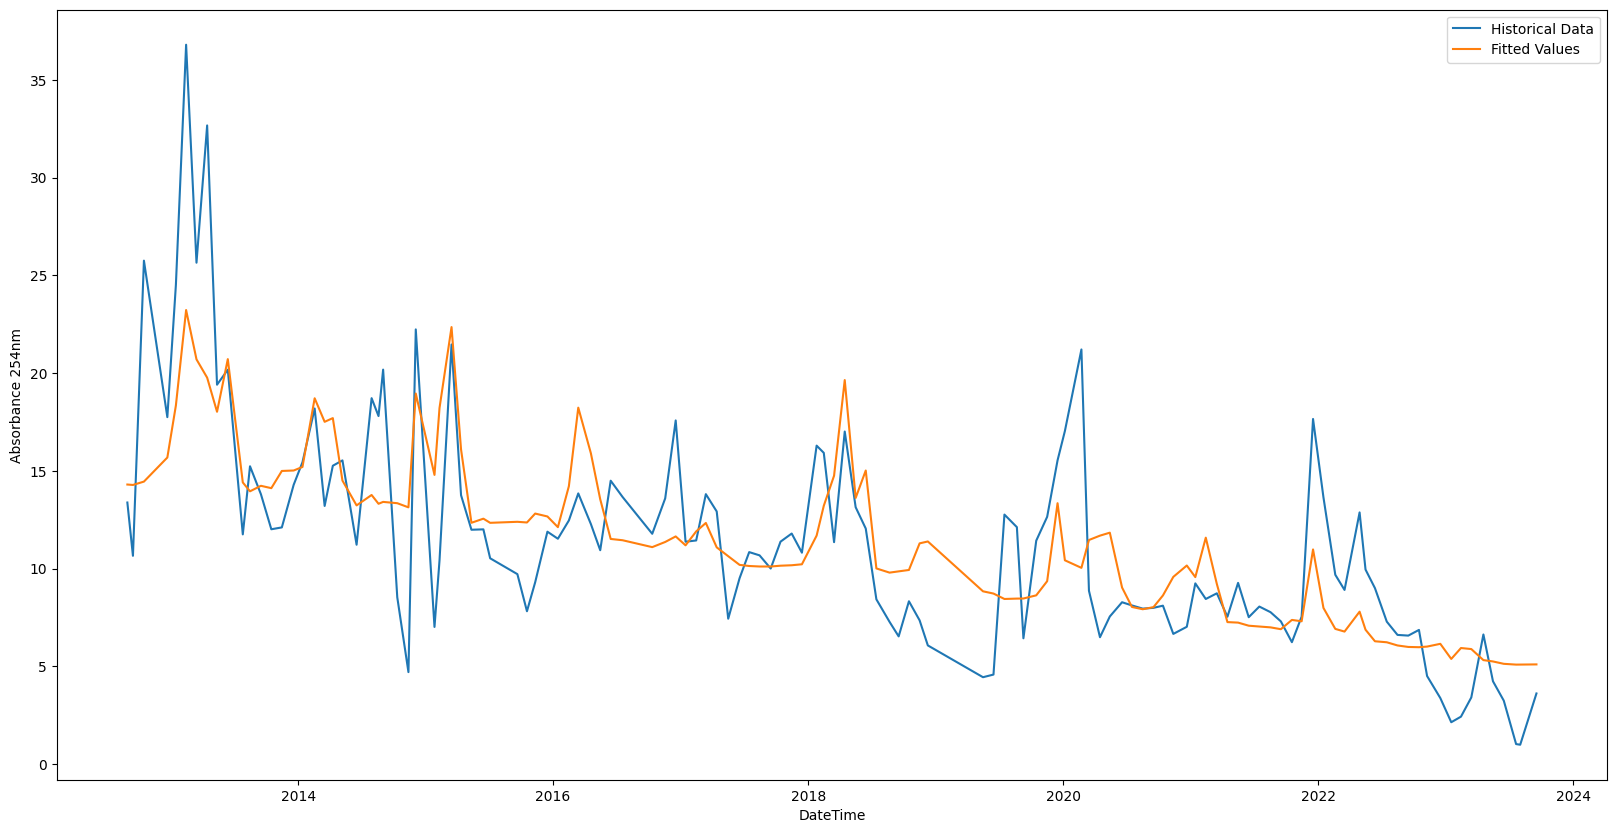

In [85]:
# plot the time series fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=y_train_fit["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=train_predictions,
    label="Fitted Values",
)

plt.show()

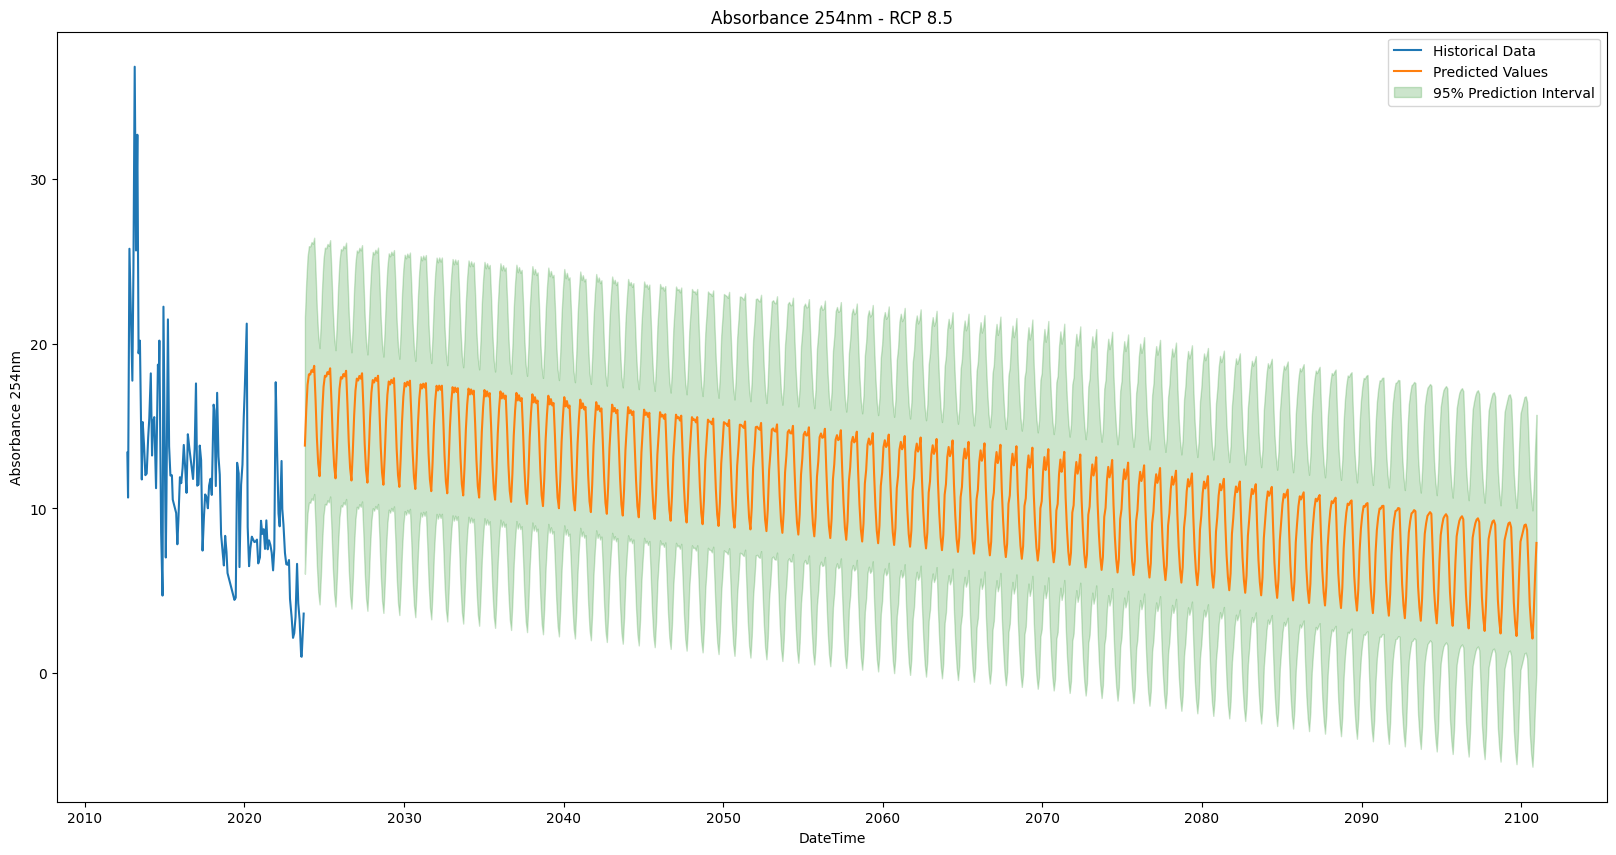

In [86]:
# all the predictions
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )


sns.lineplot(x=rcp45_test_df['DateTime'], y=y_med, label=f"Predicted Values")
# plot std of predictions
plt.fill_between(
    rcp45_test_df['DateTime'],
    y_lower,
    y2=y_upper,
    alpha=0.2,
    label="95% Prediction Interval",
    color="g",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box

plt.title(
    f"Absorbance 254nm - RCP 8.5"
)

plt.legend()
plt.show()

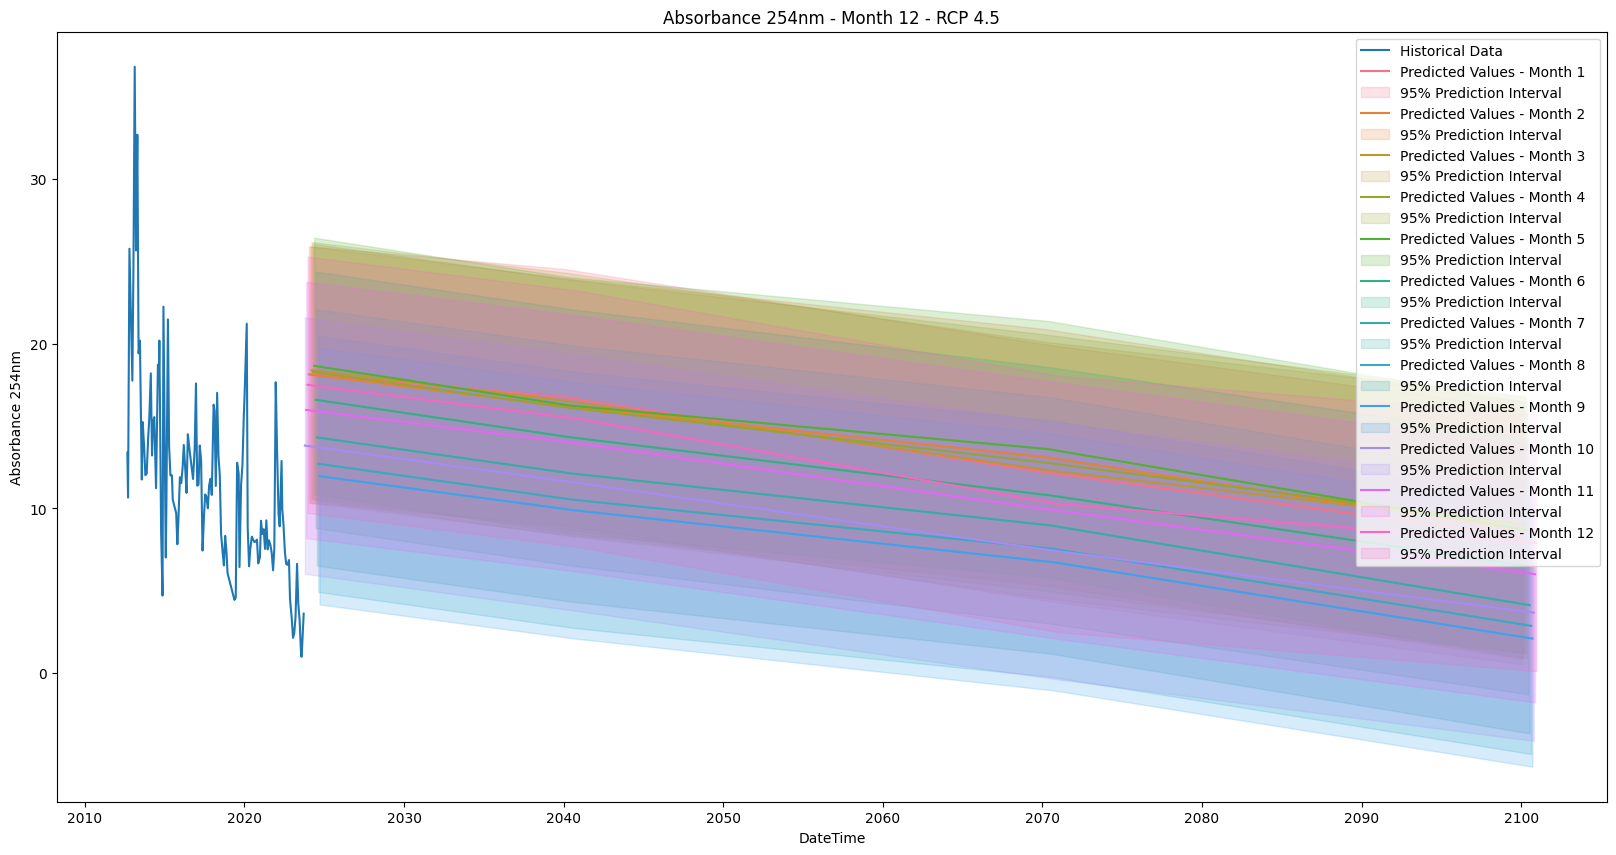

In [87]:
# predictions per month
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )

# give me a list of 12 colors
colors = sns.color_palette("husl", 12)

for month in range(1, 13):
    y_med_month = predictions_per_month[month]["y_med"]
    y_lower_month = predictions_per_month[month]["y_lower"]
    y_upper_month = predictions_per_month[month]["y_upper"]
    
    

    # plot the time series fitted values

    sns.lineplot(x=rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]['DateTime'], y=y_med_month, label=f"Predicted Values - Month {month}", color=colors[month-1])
    # plot std of predictions
    plt.fill_between(
        rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]['DateTime'],
        y_lower_month,
        y2=y_upper_month,
        alpha=0.2,
        label="95% Prediction Interval",
        color=colors[month-1],
    )
    plt.xlabel("DateTime")
    plt.ylabel("Absorbance 254nm")

    # add rmse and r2 to the plot in a box

    plt.title(
        f"Absorbance 254nm - Month {month} - RCP 4.5"
    )

    plt.legend()
plt.show()

##### Store Results

In [88]:
lgbm_pred = y_med
lgbm_lower_bound = y_lower
lgbm_upper_bound = y_upper

#### RCP 8.5

##### Prepare Data

In [89]:
further_features = ['Year']

last_train_date = full_df['DateTime'].max()

rcp85_test_df = rcp85_df[rcp85_df['DateTime'] > last_train_date]

In [90]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    rcp85_test_df[rcp85_test_df.columns.difference(["DateTime"])]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        rcp85_test_df.columns.difference(["DateTime"])
    ),
)

X_poly["DateTime"] = rcp85_test_df["DateTime"].values

In [91]:
X_test_fit = X_poly[X_poly.columns.difference(["DateTime"])]

In [92]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_poly.columns.difference(["DateTime"])
)

In [93]:
X_test_fit = rcp85_test_df[rcp85_test_df.columns.difference(["DateTime"])]

In [94]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=rcp85_test_df.columns.difference(["DateTime"])
)

##### Train Model

In [95]:
# sort the columns
X_train_fit = X_train_fit.reindex(sorted(X_train_fit.columns), axis=1)
X_test_fit = X_test_fit.reindex(sorted(X_test_fit.columns), axis=1)

In [96]:
params = {
    'n_estimators': 16,
    'learning_rate': 0.6192800859019298,
    'max_depth': 16,
    'num_leaves': 20,
    'min_data_in_leaf': 34,
    'lambda_l1': 1.8585248563175933,
    'lambda_l2': 0.020368547806226774,
    'min_split_gain': 2.5,
    'subsample': 0.5639096844841955,
    'bagging_fraction': 0.026474369917739878,
    'feature_fraction': 0.0012608584366219668,
    'min_child_samples': 33,
    'max_bin': 20
}

###### Train model with mapie

In [97]:
alpha = 0.1
estimator = LGBMRegressor(
    objective="regression", random_state=42, linear_tree=True, **params
)

estimator.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

[LightGBM] [Warning] lambda_l1 is set=1.8585248563175933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8585248563175933
[LightGBM] [Warning] lambda_l2 is set=0.020368547806226774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020368547806226774
[LightGBM] [Warning] bagging_fraction is set=0.026474369917739878, subsample=0.5639096844841955 will be ignored. Current value: bagging_fraction=0.026474369917739878
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.0012608584366219668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0012608584366219668
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1.8585248563175933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8585248563175933
[LightGBM] [Warning] lambda_l2 is set=0.020368547806226774, reg_lamb

LGBMRegressor(bagging_fraction=0.026474369917739878,
              feature_fraction=0.0012608584366219668,
              lambda_l1=1.8585248563175933, lambda_l2=0.020368547806226774,
              learning_rate=0.6192800859019298, linear_tree=True, max_bin=20,
              max_depth=16, min_child_samples=33, min_data_in_leaf=34,
              min_split_gain=2.5, n_estimators=16, num_leaves=20,
              objective='regression', random_state=42,
              subsample=0.5639096844841955)

##### Feature Importance

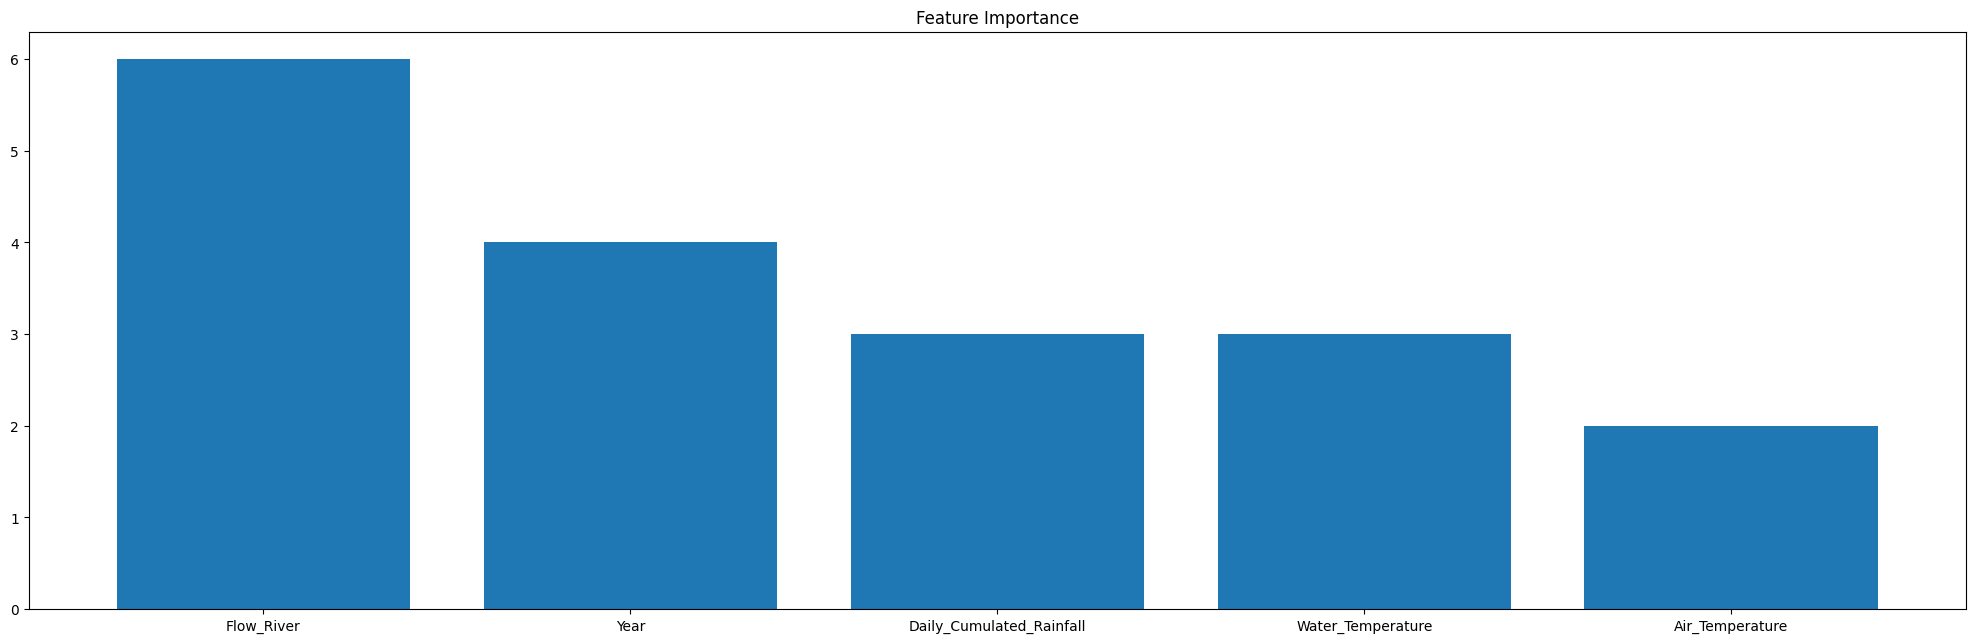

In [98]:
# show the importance of each feature in the model
feature_importance = pd.DataFrame()
feature_importance["feature"] = estimator.feature_name_
feature_importance["importance"] = estimator.feature_importances_

feature_importance = feature_importance.sort_values(
    by="importance", ascending=False
)

# plot the importance of each feature
plt.figure(figsize=(25, 7.5))
plt.bar(
    x=feature_importance["feature"],
    height=feature_importance["importance"],
)
plt.title("Feature Importance")
plt.show()

##### Predictions

In [99]:
# add month to the test data to get the predictions
X_test_fit['Month'] = rcp85_test_df['DateTime'].dt.month.values

In [100]:
alpha = 0.05

predictions_per_month = {}

# Evaluate prediction and coverage level on testing set for each month
for month in range(1, 13):
    test_fit = X_test_fit[X_test_fit["Month"] == month]
    rcp85_test_df[rcp85_test_df['DateTime'].dt.month == month]
    
    # drop the month column
    test_fit = test_fit[test_fit.columns.difference(["Month"])]
    
    y_med_month, y_pis_cqr = mapie_cqr.predict(test_fit, alpha=alpha)
    y_lower_month = y_pis_cqr[:, 0, 0]
    y_upper_month = y_pis_cqr[:, 1, 0]
    
    predictions_per_month[month] = {
        "y_med": y_med_month,
        "y_lower": y_lower_month,
        "y_upper": y_upper_month,
    }

In [101]:
X_test_fit.drop(columns=['Month'], inplace=True)

In [102]:
# evaluate on all the months
y_med, y_pis_cqr = mapie_cqr.predict(X_test_fit, alpha=alpha)
y_lower = y_pis_cqr[:, 0, 0]
y_upper = y_pis_cqr[:, 1, 0]

##### Plots

In [103]:
# get training residuals
train_predictions, _ = mapie_cqr.predict(X_train_fit, alpha=alpha)
train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

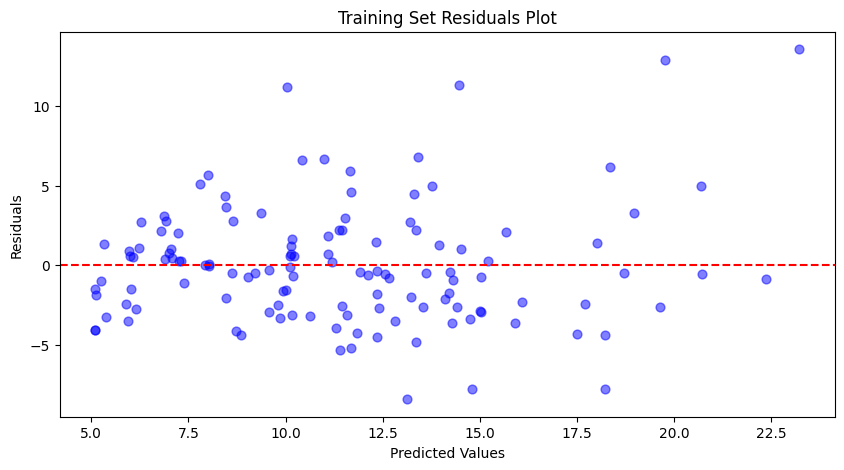

In [104]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

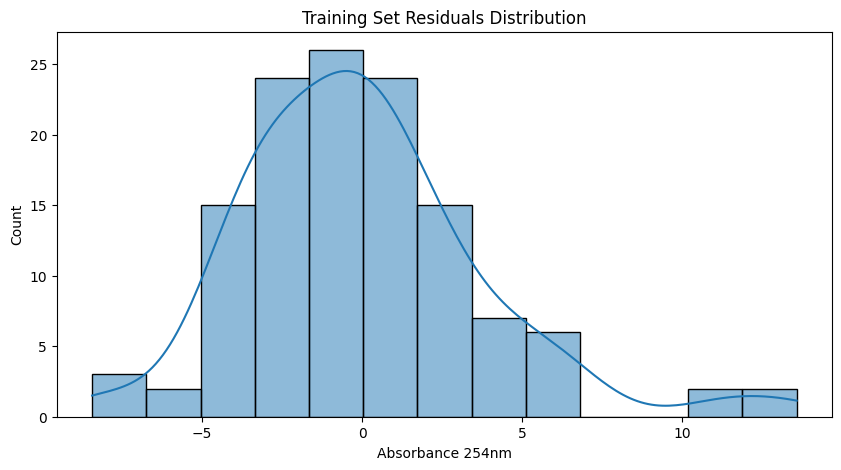

In [105]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

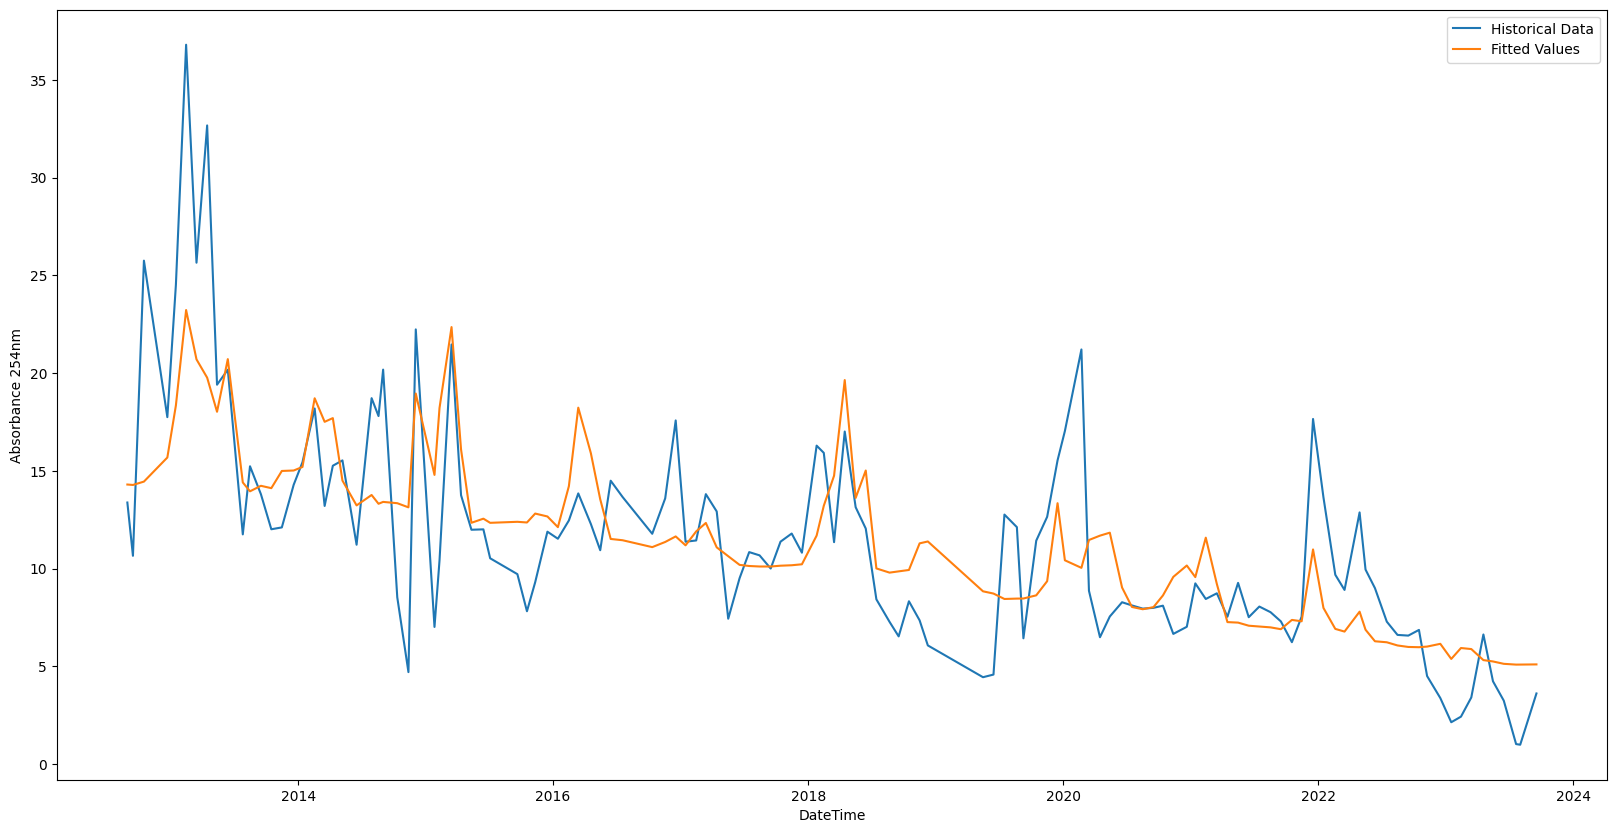

In [106]:
# plot the time series fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=y_train_fit["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=train_predictions,
    label="Fitted Values",
)

plt.show()

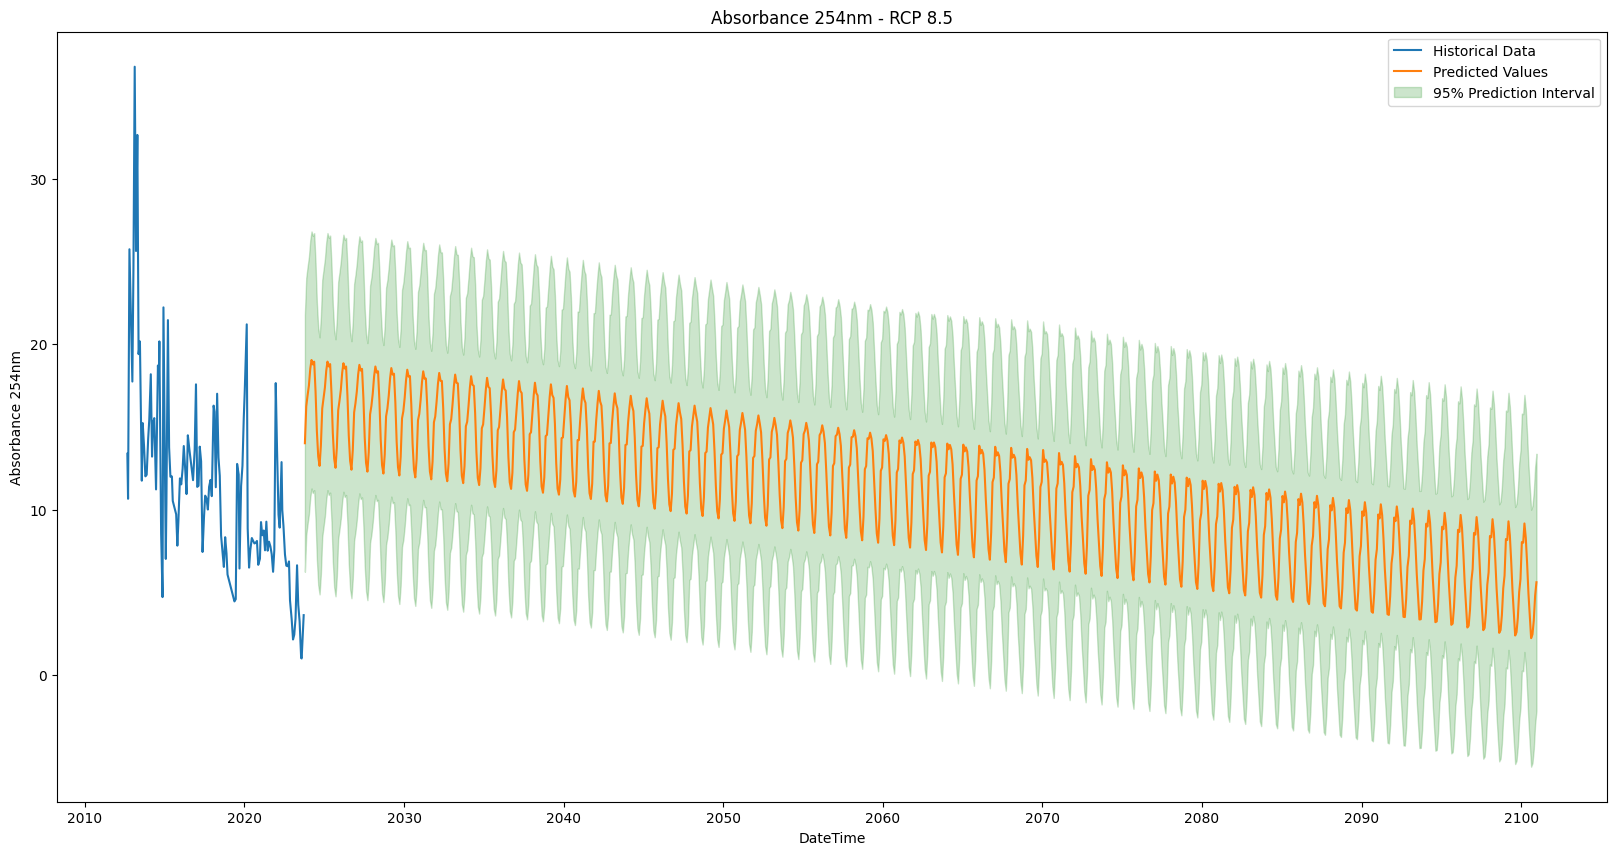

In [107]:
# all the predictions
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )


sns.lineplot(x=rcp85_test_df['DateTime'], y=y_med, label=f"Predicted Values")
# plot std of predictions
plt.fill_between(
    rcp85_test_df['DateTime'],
    y_lower,
    y2=y_upper,
    alpha=0.2,
    label="95% Prediction Interval",
    color="g",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box

plt.title(
    f"Absorbance 254nm - RCP 8.5"
)

plt.legend()
plt.show()

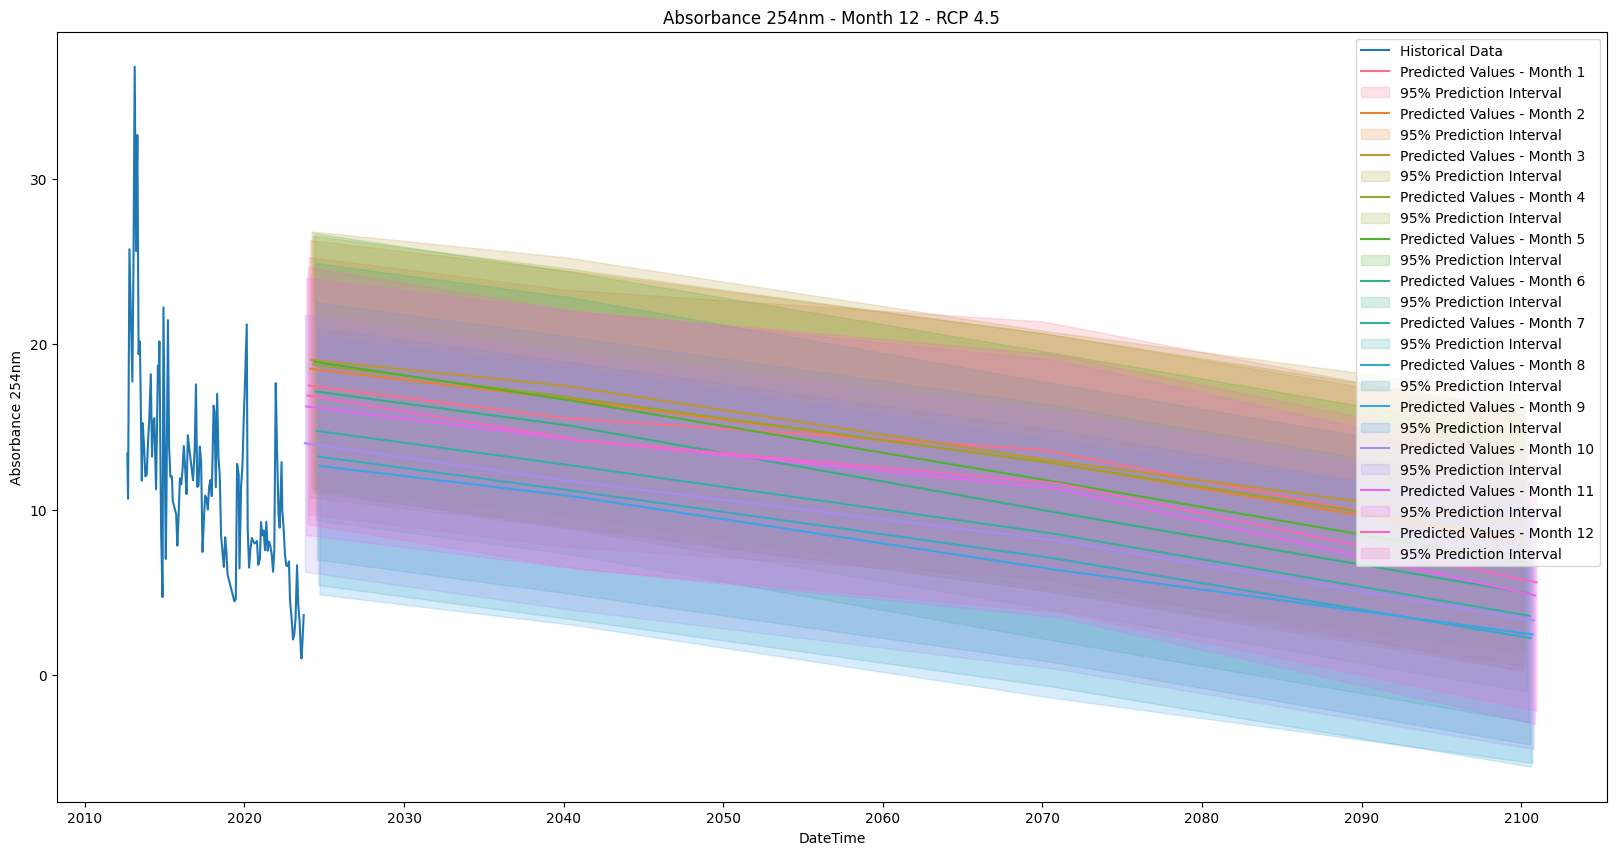

In [108]:
# predictions per month
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )

# give me a list of 12 colors
colors = sns.color_palette("husl", 12)

for month in range(1, 13):
    y_med_month = predictions_per_month[month]["y_med"]
    y_lower_month = predictions_per_month[month]["y_lower"]
    y_upper_month = predictions_per_month[month]["y_upper"]
    
    

    # plot the time series fitted values

    sns.lineplot(x=rcp85_test_df[rcp85_test_df['DateTime'].dt.month == month]['DateTime'], y=y_med_month, label=f"Predicted Values - Month {month}", color=colors[month-1])
    # plot std of predictions
    plt.fill_between(
        rcp85_test_df[rcp85_test_df['DateTime'].dt.month == month]['DateTime'],
        y_lower_month,
        y2=y_upper_month,
        alpha=0.2,
        label="95% Prediction Interval",
        color=colors[month-1],
    )
    plt.xlabel("DateTime")
    plt.ylabel("Absorbance 254nm")

    # add rmse and r2 to the plot in a box

    plt.title(
        f"Absorbance 254nm - Month {month} - RCP 4.5"
    )

    plt.legend()
plt.show()

##### Store Results

In [109]:
lgbm_pred = y_med
lgbm_lower_bound = y_lower
lgbm_upper_bound = y_upper

### Neural Network

#### RCP 4.5

##### Prepare Data

In [110]:
further_features = ['Year']

last_train_date = full_df['DateTime'].max()

rcp45_test_df = rcp45_df[rcp45_df['DateTime'] > last_train_date]

In [111]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    rcp45_test_df[rcp45_test_df.columns.difference(["DateTime"])]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        rcp45_test_df.columns.difference(["DateTime"])
    ),
)

X_poly["DateTime"] = rcp45_test_df["DateTime"].values

In [112]:
X_test_fit = X_poly[X_poly.columns.difference(["DateTime"])]

In [113]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_poly.columns.difference(["DateTime"])
)

In [114]:
X_test_fit = rcp45_test_df[rcp45_test_df.columns.difference(["DateTime"])]

In [115]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=rcp45_test_df.columns.difference(["DateTime"])
)

##### Train the model

In [116]:
best_params = {
    'n_layers': 2,
    'n_units_0': 85,
    'n_units_1': 75,
    'activation': 'identity',
    'solver': 'adam',
    'alpha': 0.7765540584565614,
    'learning_rate': 'constant',
    'power_t': 0.3382710741601535,
    'beta_1': 0.19887581875693028,
    'beta_2': 0.984060053664114,
    'epsilon': 0.32827083622604075
}

In [117]:
hidden_layer_sizes = [
    best_params[f"n_units_{i}"] for i in range(best_params["n_layers"])
]

for i in range(best_params["n_layers"]):
    best_params.pop(f"n_units_{i}")

best_params.pop("n_layers")

2

###### Train model with mapie

In [118]:
alpha = 0.1
estimator = MLPRegressor(
    random_state=42,
    hidden_layer_sizes=hidden_layer_sizes,
    max_iter=1000,
    early_stopping=True,
    **best_params
)

# estimator.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

In [119]:
# Calibrate uncertainties on calibration set
mapie_cqr = MapieRegressor(estimator, cv=10, random_state=42)
mapie_cqr.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

MapieRegressor(cv=10,
               estimator=MLPRegressor(activation='identity',
                                      alpha=0.7765540584565614,
                                      beta_1=0.19887581875693028,
                                      beta_2=0.984060053664114,
                                      early_stopping=True,
                                      epsilon=0.32827083622604075,
                                      hidden_layer_sizes=[85, 75],
                                      max_iter=1000, power_t=0.3382710741601535,
                                      random_state=42),
               random_state=42)

##### Prediction

In [120]:
# add month to the test data to get the predictions
X_test_fit['Month'] = rcp45_test_df['DateTime'].dt.month.values

In [121]:
alpha = 0.05

predictions_per_month = {}

# Evaluate prediction and coverage level on testing set for each month
for month in range(1, 13):
    test_fit = X_test_fit[X_test_fit["Month"] == month]
    rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]
    
    # drop the month column
    test_fit = test_fit[test_fit.columns.difference(["Month"])]
    
    y_med_month, y_pis_cqr = mapie_cqr.predict(test_fit, alpha=alpha)
    y_lower_month = y_pis_cqr[:, 0, 0]
    y_upper_month = y_pis_cqr[:, 1, 0]
    
    predictions_per_month[month] = {
        "y_med": y_med_month,
        "y_lower": y_lower_month,
        "y_upper": y_upper_month,
    }

In [122]:
X_test_fit.drop(columns=['Month'], inplace=True)

In [123]:
# evaluate on all the months
y_med, y_pis_cqr = mapie_cqr.predict(X_test_fit, alpha=alpha)
y_lower = y_pis_cqr[:, 0, 0]
y_upper = y_pis_cqr[:, 1, 0]

##### Plots

In [124]:
# get training residuals
train_predictions, _ = mapie_cqr.predict(X_train_fit, alpha=alpha)
train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

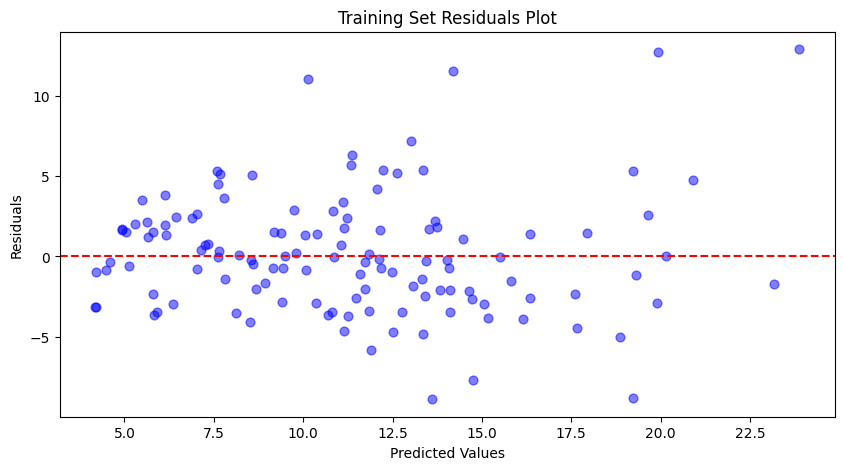

In [125]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(
    train_predictions.flatten(), train_residuals, c="b", s=40, alpha=0.5
)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

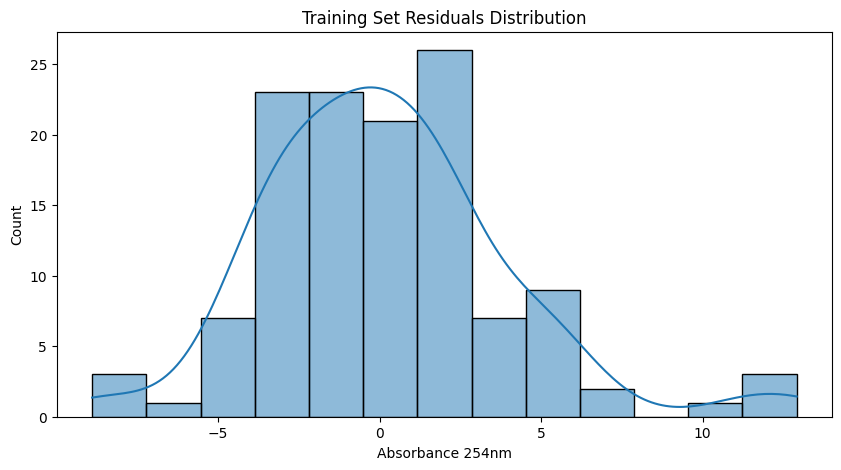

In [126]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

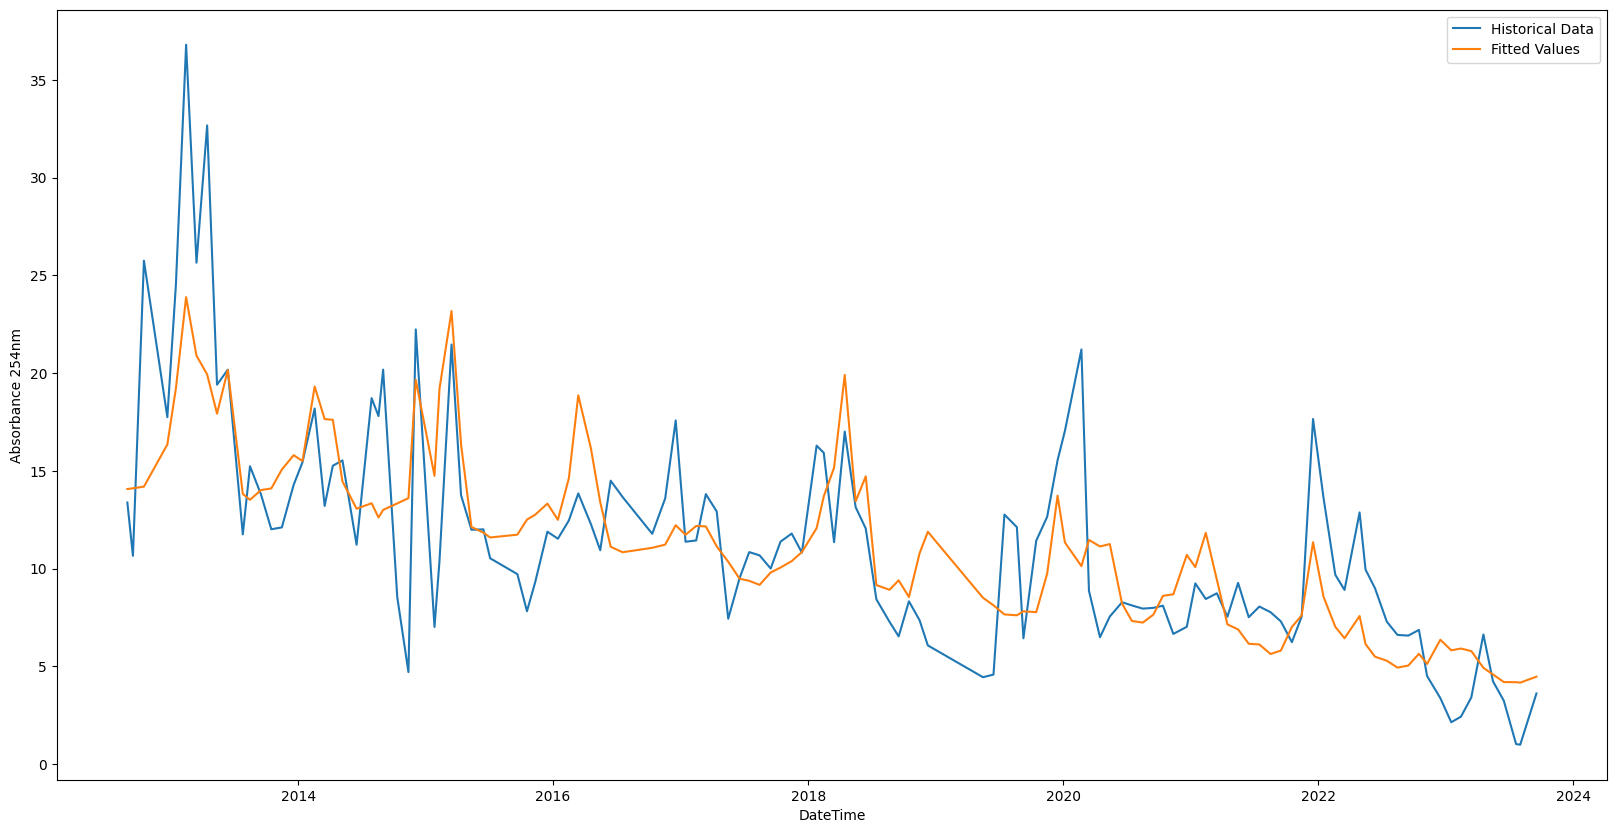

In [127]:
# plot the time series fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=y_train_fit["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=train_predictions,
    label="Fitted Values",
)

plt.show()

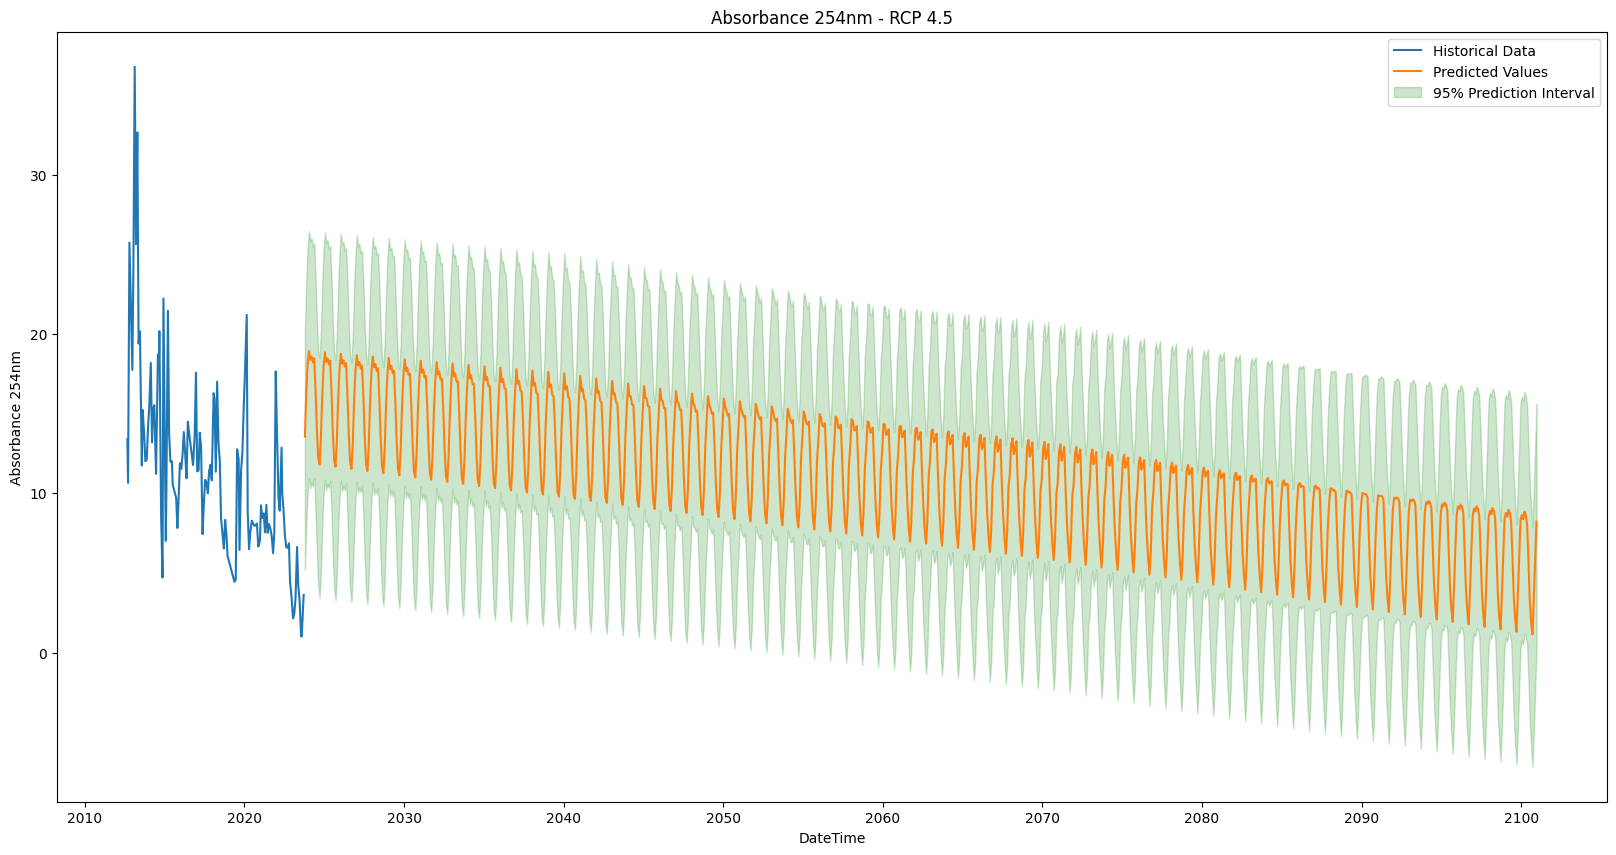

In [128]:
# all the predictions
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )


sns.lineplot(x=rcp45_test_df['DateTime'], y=y_med, label=f"Predicted Values")
# plot std of predictions
plt.fill_between(
    rcp45_test_df['DateTime'],
    y_lower,
    y2=y_upper,
    alpha=0.2,
    label="95% Prediction Interval",
    color="g",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box

plt.title(
    f"Absorbance 254nm - RCP 4.5"
)

plt.legend()
plt.show()

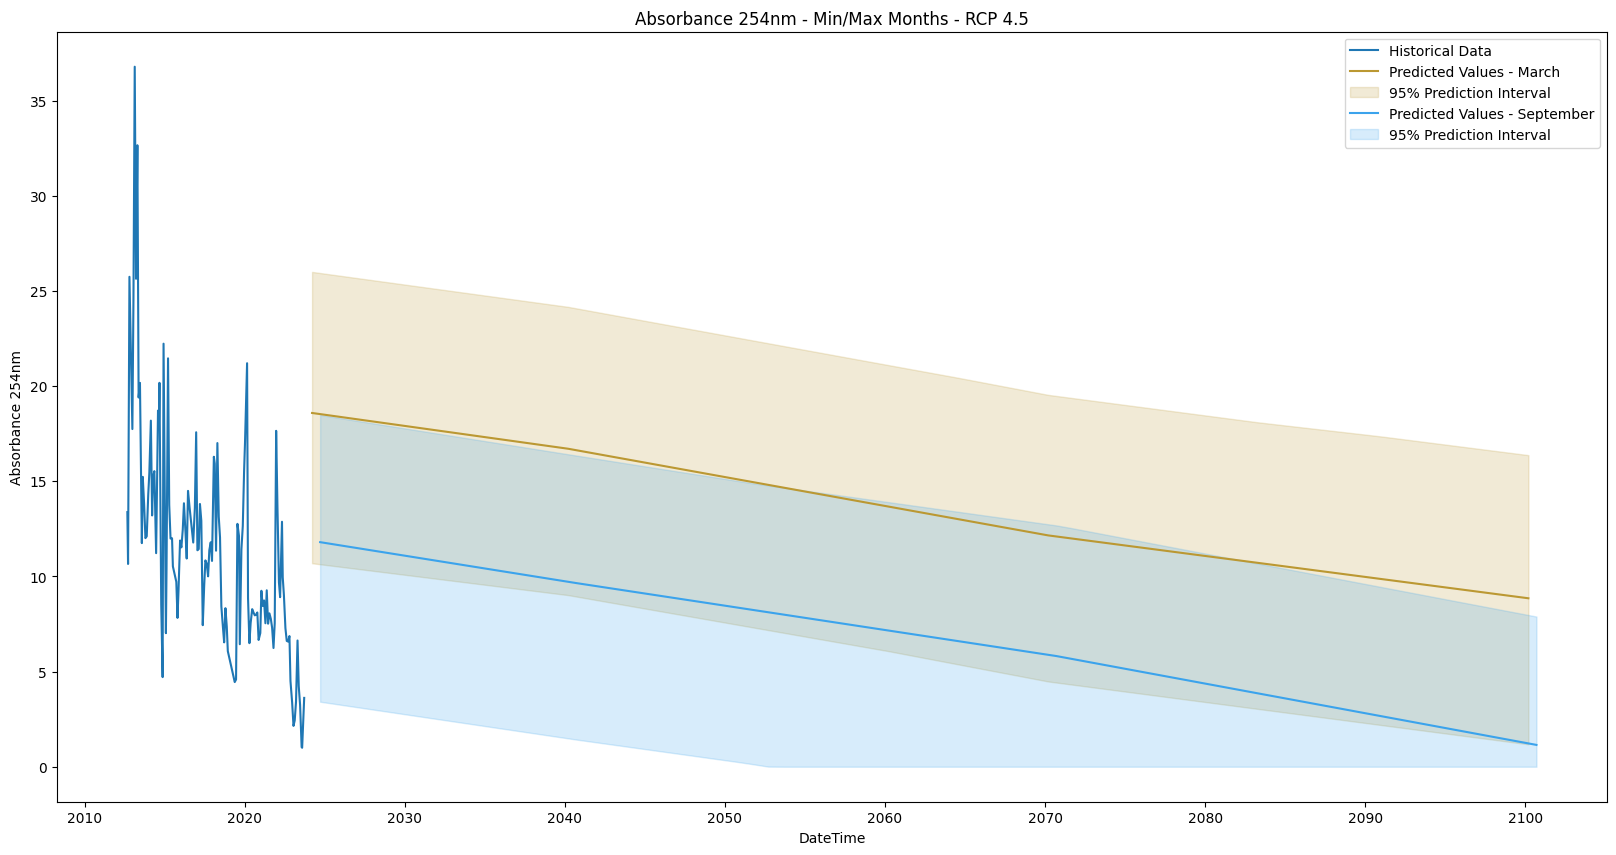

In [129]:
# predictions per month
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )

# give me a list of 12 colors
colors = sns.color_palette("husl", 12)

min_max_months = {
        3: 'March',
        9: 'September'
    }

for month, name in min_max_months.items():
    y_med_month = predictions_per_month[month]["y_med"]
    y_lower_month = predictions_per_month[month]["y_lower"]
    y_upper_month = predictions_per_month[month]["y_upper"]
    
    # y_lower_month can be negative, so we need to set it to 0
    y_lower_month = np.maximum(y_lower_month, 0)

    # plot the time series fitted values

    sns.lineplot(x=rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]['DateTime'], y=y_med_month, label=f"Predicted Values - {name}", color=colors[month-1])
    # plot std of predictions
    plt.fill_between(
        rcp45_test_df[rcp45_test_df['DateTime'].dt.month == month]['DateTime'],
        y_lower_month,
        y2=y_upper_month,
        alpha=0.2,
        label="95% Prediction Interval",
        color=colors[month-1],
    )
    plt.xlabel("DateTime")
    plt.ylabel("Absorbance 254nm")

    # add rmse and r2 to the plot in a box

    plt.title(
        f"Absorbance 254nm - Min/Max Months - RCP 4.5"
    )

    plt.legend()
plt.show()

##### Store Results

In [130]:
nn_pred = y_med
nn_lower_bound = y_lower
nn_upper_bound = y_upper

#### RCP 8.5

##### Prepare Data

In [131]:
further_features = ['Year']

last_train_date = full_df['DateTime'].max()

rcp85_test_df = rcp85_df[rcp85_df['DateTime'] > last_train_date]

In [132]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    rcp85_test_df[rcp85_test_df.columns.difference(["DateTime"])]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        rcp85_test_df.columns.difference(["DateTime"])
    ),
)

X_poly["DateTime"] = rcp85_test_df["DateTime"].values

In [133]:
X_test_fit = X_poly[X_poly.columns.difference(["DateTime"])]

In [134]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_poly.columns.difference(["DateTime"])
)

In [135]:
X_test_fit = rcp85_test_df[rcp85_test_df.columns.difference(["DateTime"])]

In [136]:
scaler = StandardScaler()
# scale the data and keep the column names
X_test_fit = scaler.fit_transform(X_test_fit)

X_test_fit = pd.DataFrame(
    X_test_fit, columns=rcp85_test_df.columns.difference(["DateTime"])
)

##### Train the model

In [137]:
best_params = {
    'n_layers': 2,
    'n_units_0': 85,
    'n_units_1': 75,
    'activation': 'identity',
    'solver': 'adam',
    'alpha': 0.7765540584565614,
    'learning_rate': 'constant',
    'power_t': 0.3382710741601535,
    'beta_1': 0.19887581875693028,
    'beta_2': 0.984060053664114,
    'epsilon': 0.32827083622604075
}

In [138]:
hidden_layer_sizes = [
    best_params[f"n_units_{i}"] for i in range(best_params["n_layers"])
]

for i in range(best_params["n_layers"]):
    best_params.pop(f"n_units_{i}")

best_params.pop("n_layers")

2

###### Train model with mapie

In [139]:
alpha = 0.05
estimator = MLPRegressor(
    random_state=42,
    hidden_layer_sizes=hidden_layer_sizes,
    max_iter=1000,
    early_stopping=True,
    **best_params
)

# estimator.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

In [140]:
# Calibrate uncertainties on calibration set
mapie_cqr = MapieRegressor(estimator, random_state=42)
mapie_cqr.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

MapieRegressor(estimator=MLPRegressor(activation='identity',
                                      alpha=0.7765540584565614,
                                      beta_1=0.19887581875693028,
                                      beta_2=0.984060053664114,
                                      early_stopping=True,
                                      epsilon=0.32827083622604075,
                                      hidden_layer_sizes=[85, 75],
                                      max_iter=1000, power_t=0.3382710741601535,
                                      random_state=42),
               random_state=42)

##### Prediction

In [141]:
# add month to the test data to get the predictions
X_test_fit['Month'] = rcp85_test_df['DateTime'].dt.month.values

In [142]:
alpha = 0.05

predictions_per_month = {}

# Evaluate prediction and coverage level on testing set for each month
for month in range(1, 13):
    test_fit = X_test_fit[X_test_fit["Month"] == month]
    rcp45_test_df[rcp85_test_df['DateTime'].dt.month == month]
    
    # drop the month column
    test_fit = test_fit[test_fit.columns.difference(["Month"])]
    
    y_med_month, y_pis_cqr = mapie_cqr.predict(test_fit, alpha=alpha)
    y_lower_month = y_pis_cqr[:, 0, 0]
    y_upper_month = y_pis_cqr[:, 1, 0]
    
    predictions_per_month[month] = {
        "y_med": y_med_month,
        "y_lower": y_lower_month,
        "y_upper": y_upper_month,
    }

In [143]:
X_test_fit.drop(columns=['Month'], inplace=True)

In [144]:
# evaluate on all the months
y_med, y_pis_cqr = mapie_cqr.predict(X_test_fit, alpha=alpha)
y_lower = y_pis_cqr[:, 0, 0]
y_upper = y_pis_cqr[:, 1, 0]

##### Plots

In [145]:
# get training residuals
train_predictions, _ = mapie_cqr.predict(X_train_fit, alpha=alpha)
train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

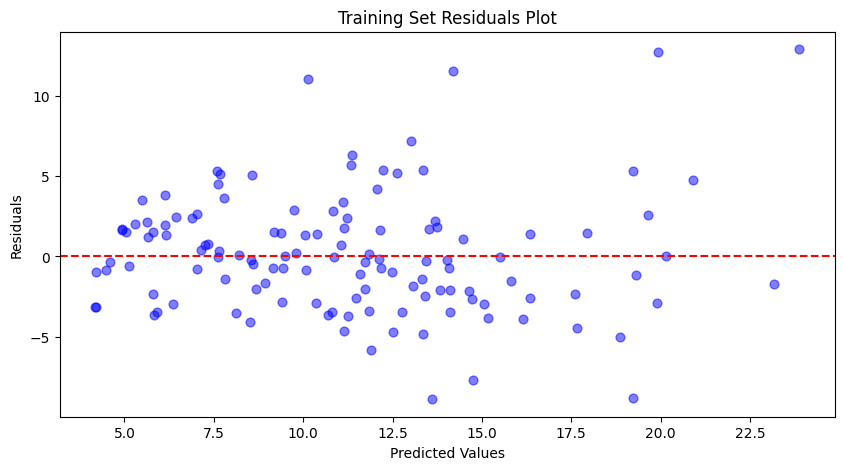

In [146]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(
    train_predictions.flatten(), train_residuals, c="b", s=40, alpha=0.5
)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

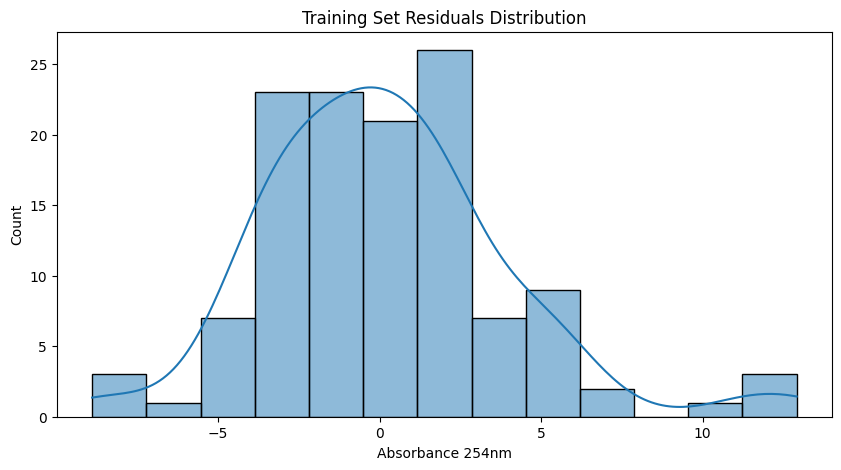

In [147]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

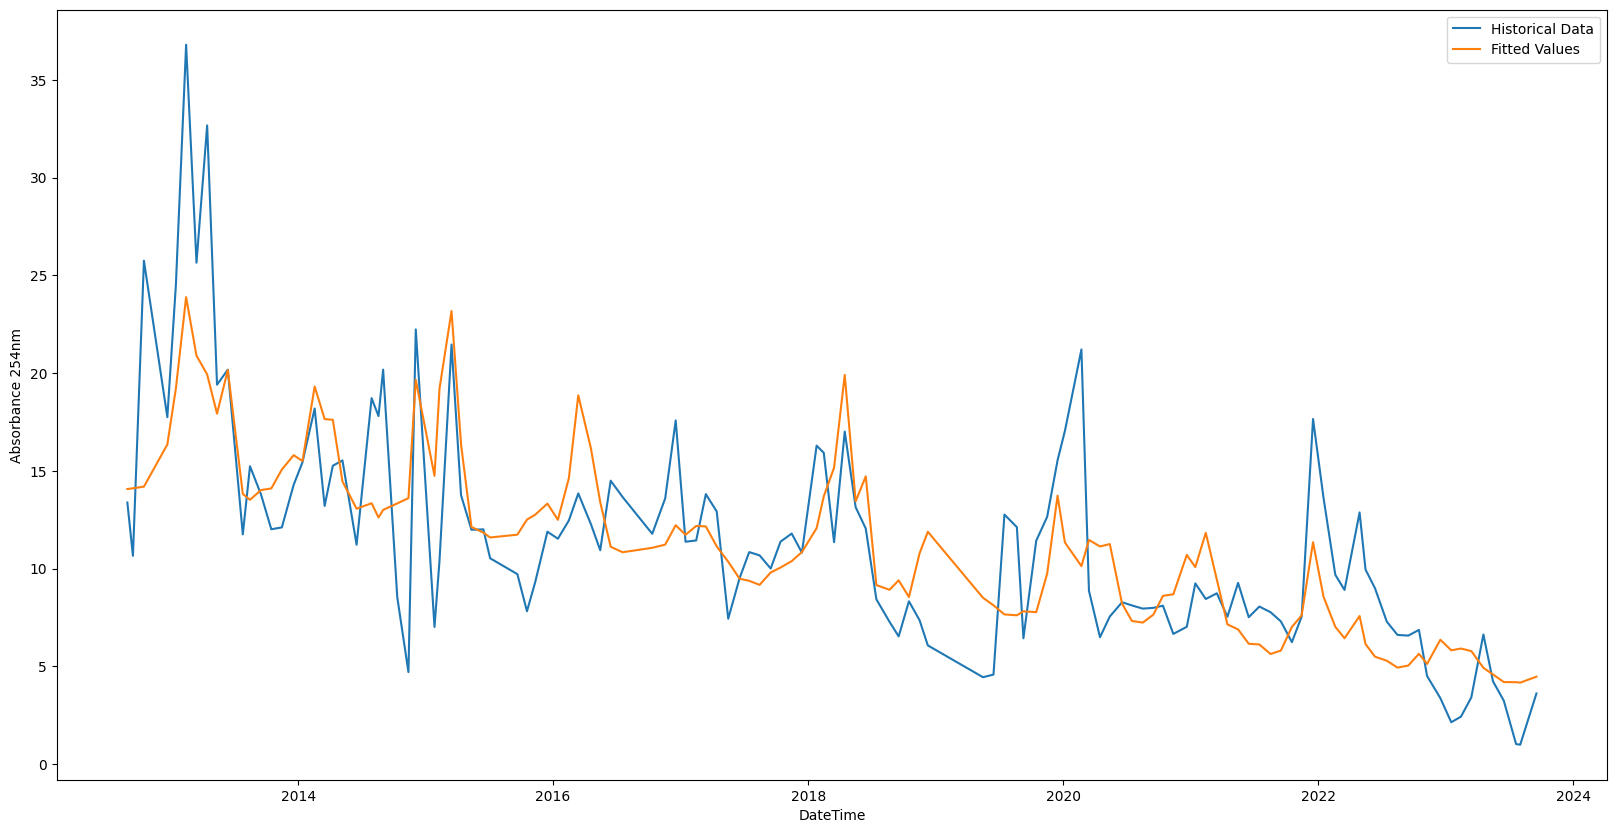

In [148]:
# plot the time series fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=y_train_fit["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=train_predictions,
    label="Fitted Values",
)

plt.show()

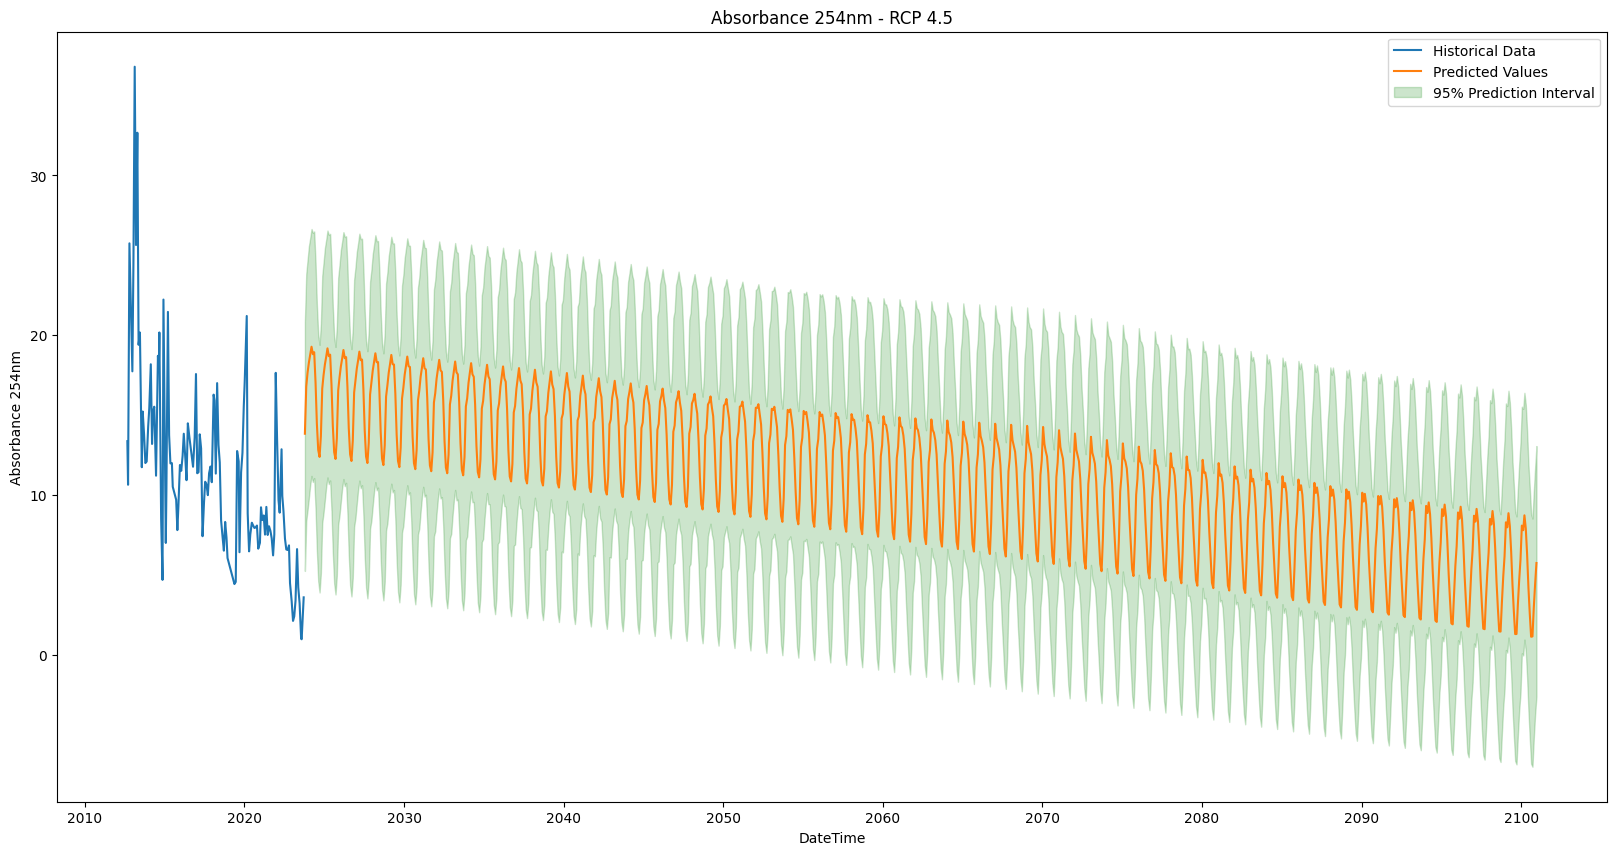

In [149]:
# all the predictions
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )


sns.lineplot(x=rcp45_test_df['DateTime'], y=y_med, label=f"Predicted Values")
# plot std of predictions
plt.fill_between(
    rcp45_test_df['DateTime'],
    y_lower,
    y2=y_upper,
    alpha=0.2,
    label="95% Prediction Interval",
    color="g",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box

plt.title(
    f"Absorbance 254nm - RCP 4.5"
)

plt.legend()
plt.show()

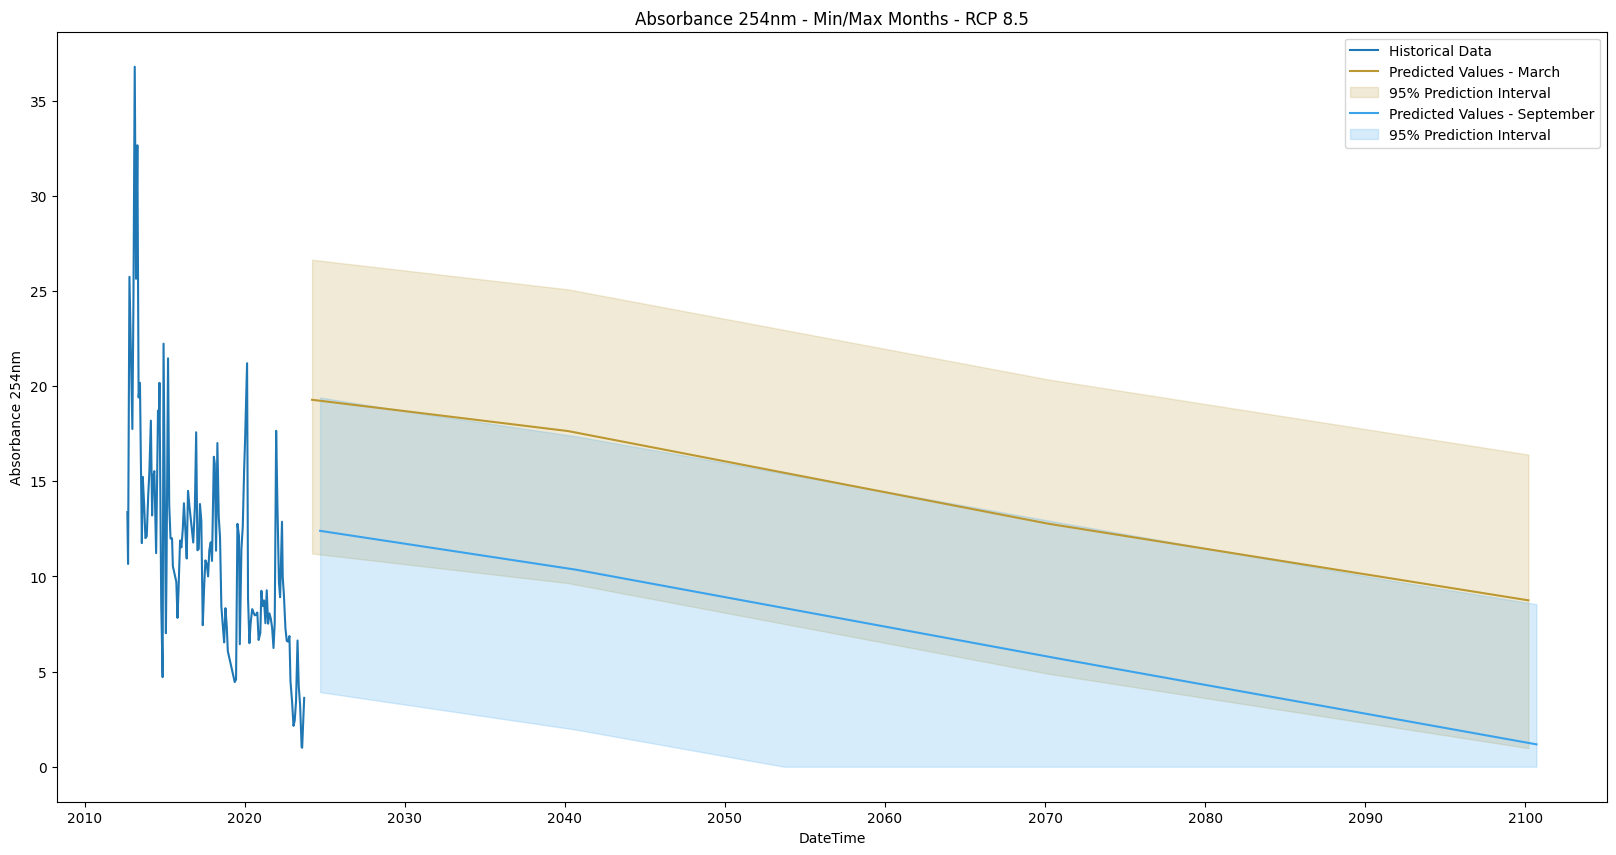

In [150]:
# predictions per month
plt.figure(figsize=(20, 10))

sns.lineplot(
        x=y["DateTime"],
        y=y["Absorbance 254nm"],
        label="Historical Data",
    )

# give me a list of 12 colors
colors = sns.color_palette("husl", 12)

min_max_months = {
        3: 'March',
        9: 'September'
    }

for month, name in min_max_months.items():
    y_med_month = predictions_per_month[month]["y_med"]
    y_lower_month = predictions_per_month[month]["y_lower"]
    y_upper_month = predictions_per_month[month]["y_upper"]
    
    # y_lower values cannot be negative
    y_lower_month = np.maximum(y_lower_month, 0)

    # plot the time series fitted values

    sns.lineplot(x=rcp45_test_df[rcp85_test_df['DateTime'].dt.month == month]['DateTime'], y=y_med_month, label=f"Predicted Values - {name}", color=colors[month-1])
    # plot std of predictions
    plt.fill_between(
        rcp45_test_df[rcp85_test_df['DateTime'].dt.month == month]['DateTime'],
        y_lower_month,
        y2=y_upper_month,
        alpha=0.2,
        label="95% Prediction Interval",
        color=colors[month-1],
    )
    plt.xlabel("DateTime")
    plt.ylabel("Absorbance 254nm")

    # add rmse and r2 to the plot in a box

    plt.title(
        f"Absorbance 254nm - Min/Max Months - RCP 8.5"
    )

    plt.legend()
plt.show()

##### Store Results

In [151]:
nn_pred = y_med
nn_lower_bound = y_lower
nn_upper_bound = y_upper